# LXM

> LXM: Better Splittable Pseudorandom Number Generators (and Almost as Fast)
> - Paper: https://dl.acm.org/doi/abs/10.1145/3485525
> - Video: https://youtu.be/OXurCqln_qc


En el 2021 Guy Steele y Sebastiano Vigna presentaron un generador de números pseudo aleatorios (PRNG) que se construye a partir de otro PRNG en donde colaboro Guy Steele llamado SplitMix. La principal propiedad de ambos PRNGs es que estos generadores son partibles (_splittable_), es decir, se pueden dividir en dos nuevos generadores estadísticamente independientes, lo cual es de gran utilidad en ambientes concurrentes.

LXM se basa en combinar tres ideas: un generador lineal congruente (la L), un generador basado en XORs (la X) y el resultado de la combinación de esos dos generadores utilizarlo como input en una función mezcladora (la M).

En este trabajo nos centraremos específicamente en la parte práctica del algoritmo y lo re-implementaremos en nuestro propio código, evitando hablar tanto de la concurrencia como de la propiedad partible del algoritmo (lo cual consiste de la mayoría del paper de Guy Steele y Sebastiano Vigna). Las ideas principales surgen de la sección 2 del paper (`THE LXM GENERATION ALGORITHM`)

## Ejercicio 1

Sobre el generador de números al azar propuesto en el paper asignado, se pide:
- Implementarlo en función de lo especificado en el documento.
- Modificarlo (si aplica) para obtener números al azar entre 0 y 1
- Realizar los gráficos que se consideren adecuados para mostrar las distribuciones de números al azar
generados en ambos casos (explicar que se busca interpretar con cada uno)

In [3]:
def LXM(s, m=2891336453, a=1310709051, x0=11565345, x1=5242836, k=64):
    
    # https://gist.github.com/trietptm/5cd60ed6add5adad6a34098ce255949a
    rotl = lambda val, r_bits, max_bits: \
        (val << r_bits%max_bits) & (2**max_bits-1) | \
        ((val & (2**max_bits-1)) >> (max_bits-(r_bits%max_bits)))    
    
    while True:
        # Combining operation
        z = s + x0
        # Mixing function (lea64)
        z = (z ^ (z >> 32)) * 0xdaba0b6eb09322e3
        z = (z ^ (z >> 32)) * 0xdaba0b6eb09322e3
        z = (z ^ (z >> 32))
        z &= (2**k) - 1
        # Update the LCG subgenerator
        s = (m * s + a)
        # Update the XBG subgenerator (xoroshiro128v1_0)
        q0 = x0; q1 = x1
        q1 ^= q0
        q0 = rotl(q0, 24, k)
        q0 = q0 ^ q1 ^ (q1 << 16)
        q1 = rotl(q1, 37, k)
        x0 = q0; x1 = q1
        # Return result (modified to be in interval 0-1)
        yield z/2**k
        

n = 5
print(f"{n} números generados al azar, en el intervalo 0-1:")

g = LXM(42) 
for r, i in zip(g,range(n)):
    print(f"* {r}")

5 números generados al azar, en el intervalo 0-1:
* 0.793781427453092
* 0.2155520740899848
* 0.7433470653358116
* 0.28660629734277526
* 0.515362051632894


In [ ]:
# Un poquito de setup de gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

sns.set(style="darkgrid")
params = {
    'axes.titlesize': 32,
    'axes.labelsize': 24,
    'legend.fontsize': 20,
    'figure.figsize': (25, 15),
}
pylab.rcParams.update(params)

<matplotlib.collections.PathCollection>

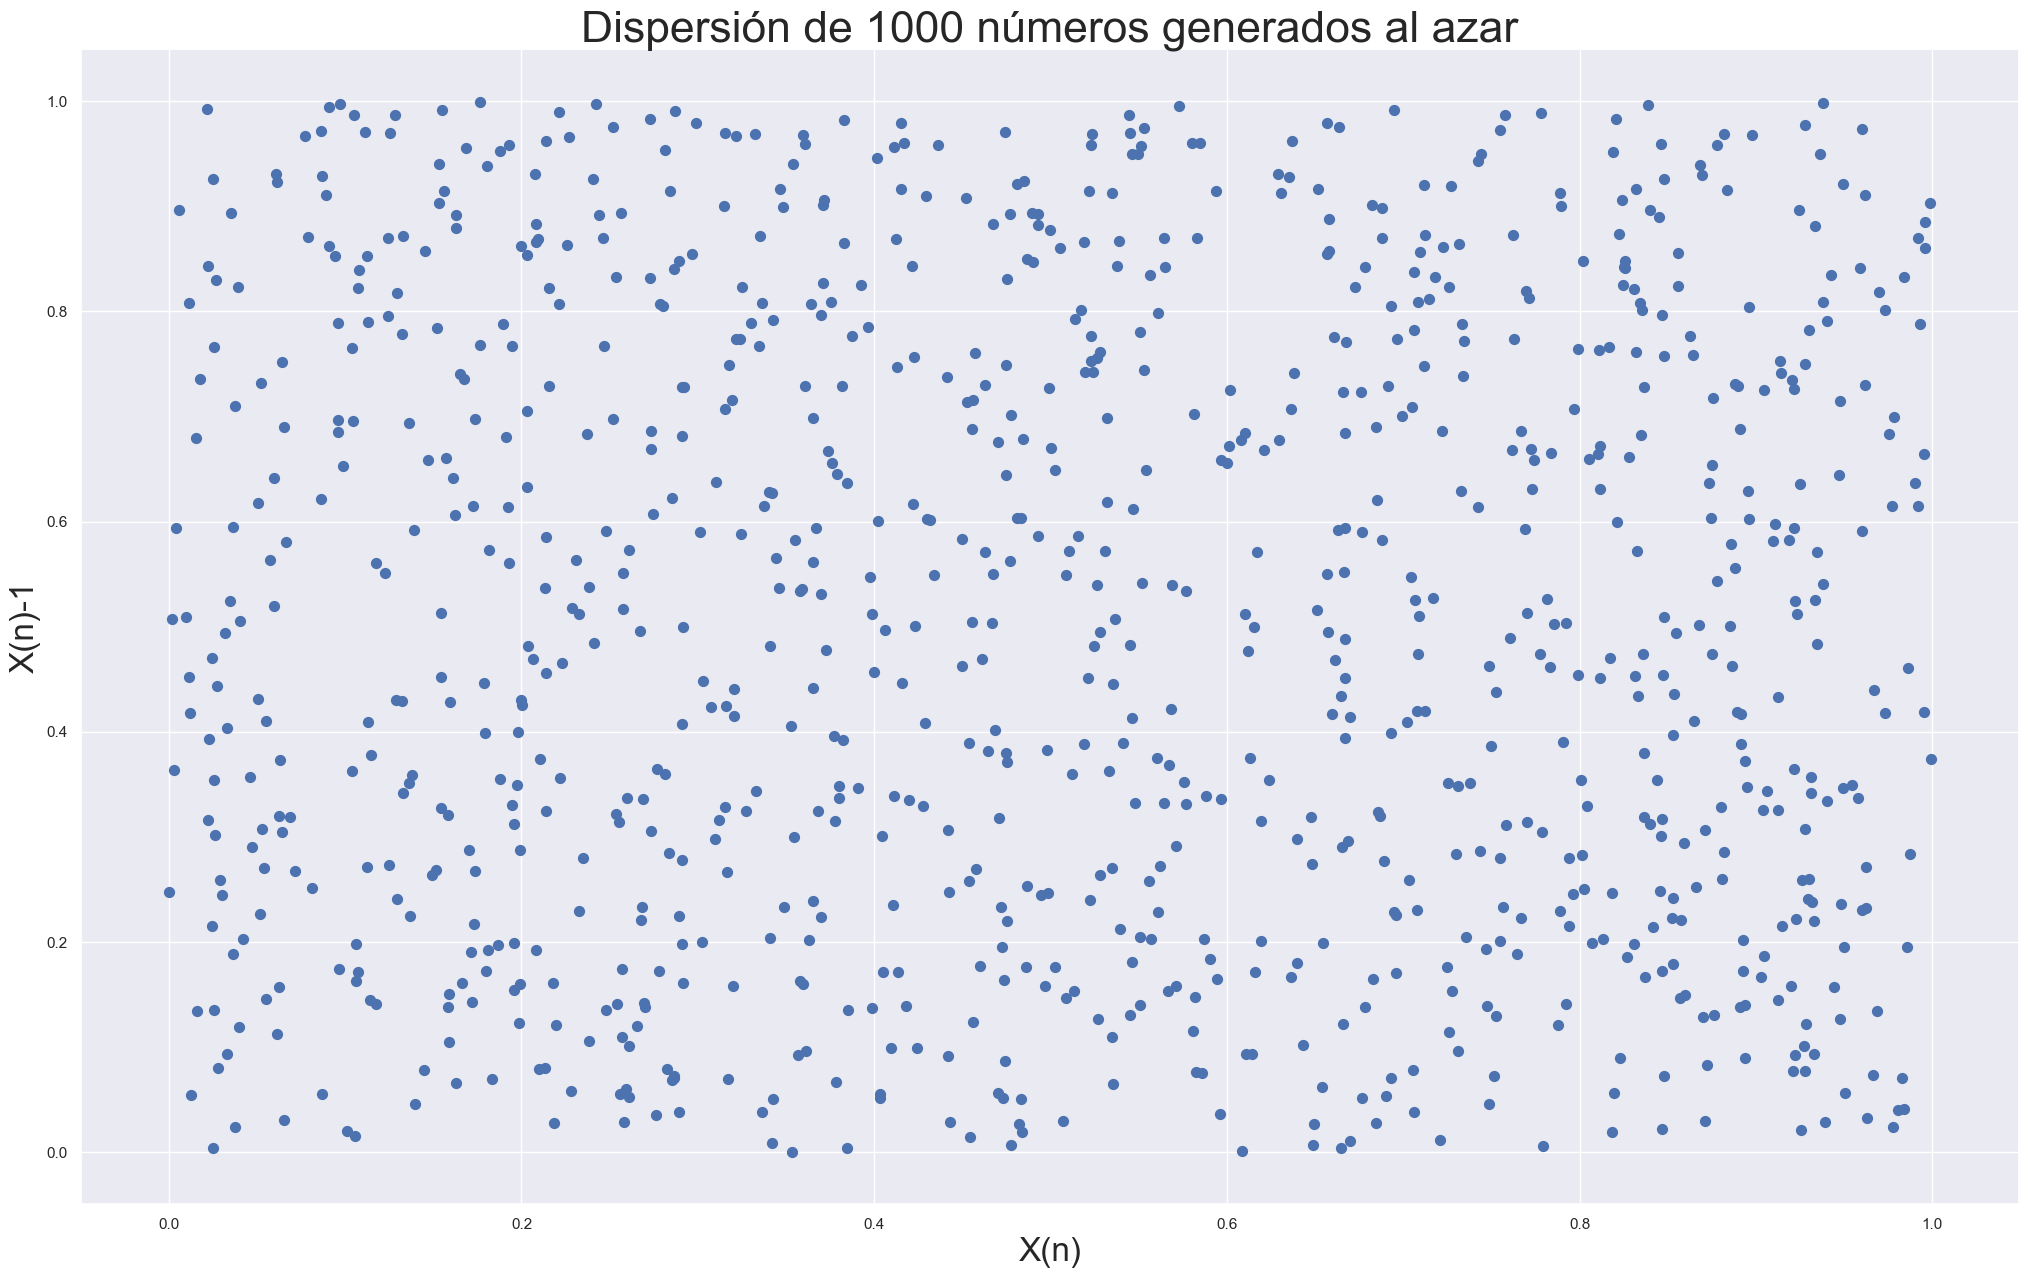

In [ ]:
# Empezamos con un scatterplot
g = LXM(42) 
n = 1000

x = []; y = []
for i in range(n):
    x.append(next(g))
    y.append(next(g))
    
plt.title(f"Dispersión de {n} números generados al azar")
plt.ylabel("X(n)-1")
plt.xlabel("X(n)")
plt.scatter(x,y,50)

En el gráfico de dispersión se pretende ver si la generación de los números sigue algún patrón. En el gráfico realizado no se observa ninguno, ya que no se ven formas claras, como por ejemplo una línea recta, ni zonas con una densidad marcadamente superior a la del resto. Lo que se observa es una "nube de puntos", que es lo que debería verse en una distribución uniforme.

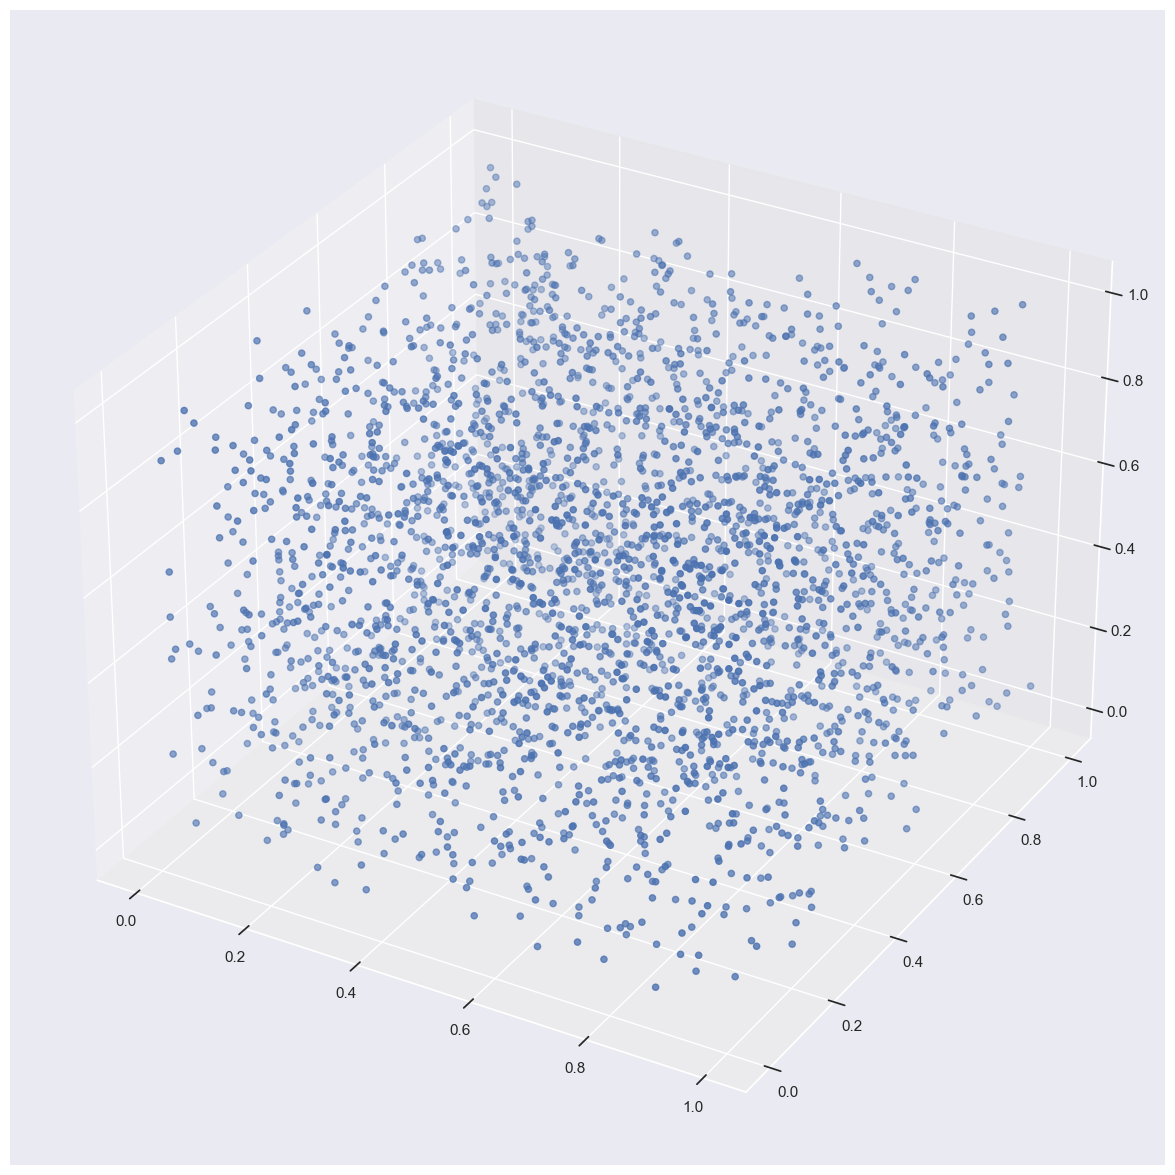

In [ ]:
# Solamente como demostración, hacemos un scatterplot 3D
g = LXM(42) 
n = 3000

fig = plt.figure()
ax = plt.axes(projection='3d')
x = []; y = []; z = []
for i in range(n):
    x.append(next(g))
    y.append(next(g))
    z.append(next(g))
ax.scatter3D(x, y, z);

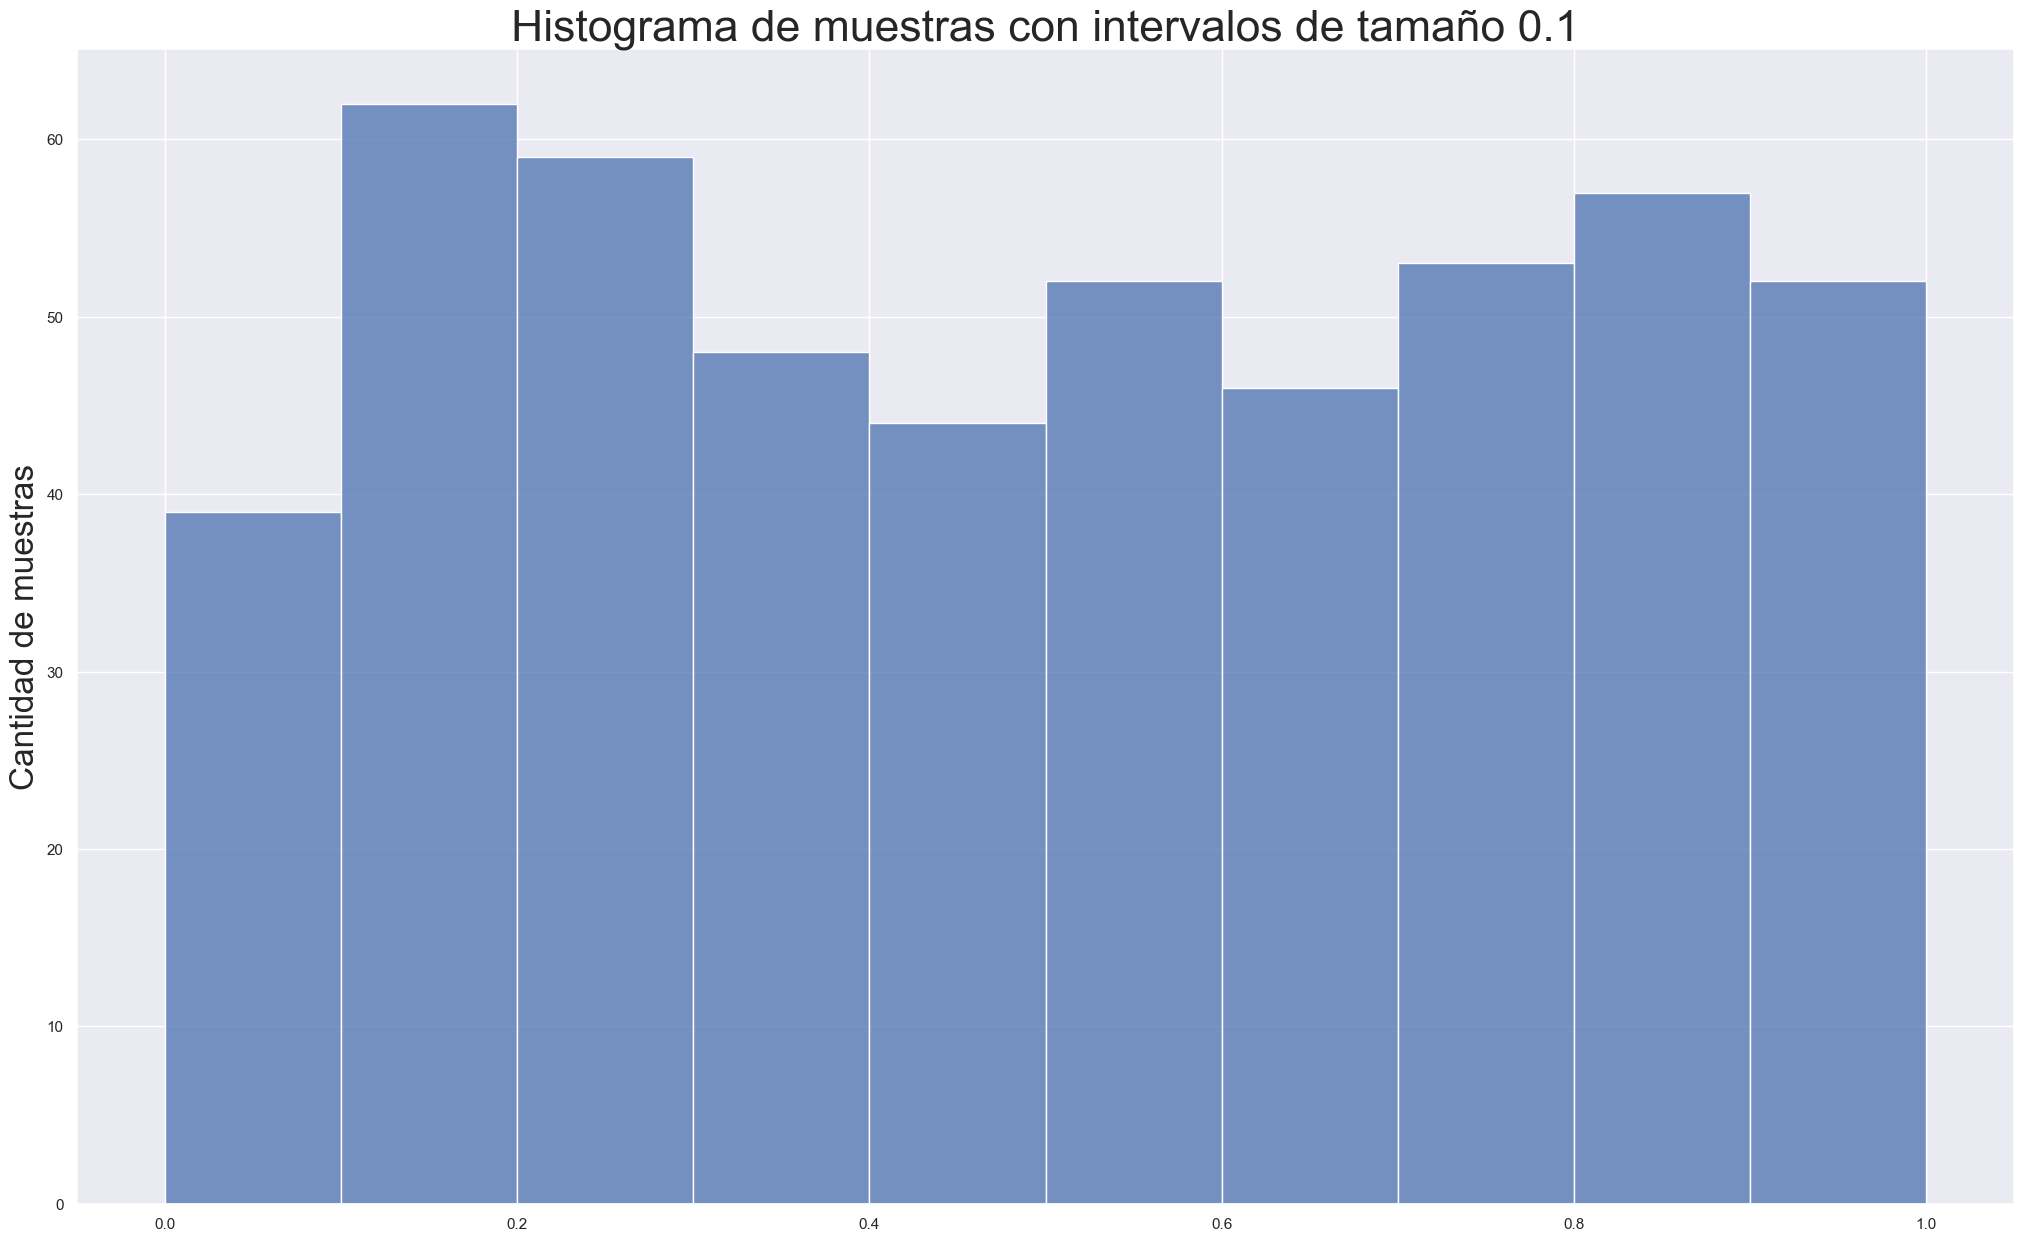

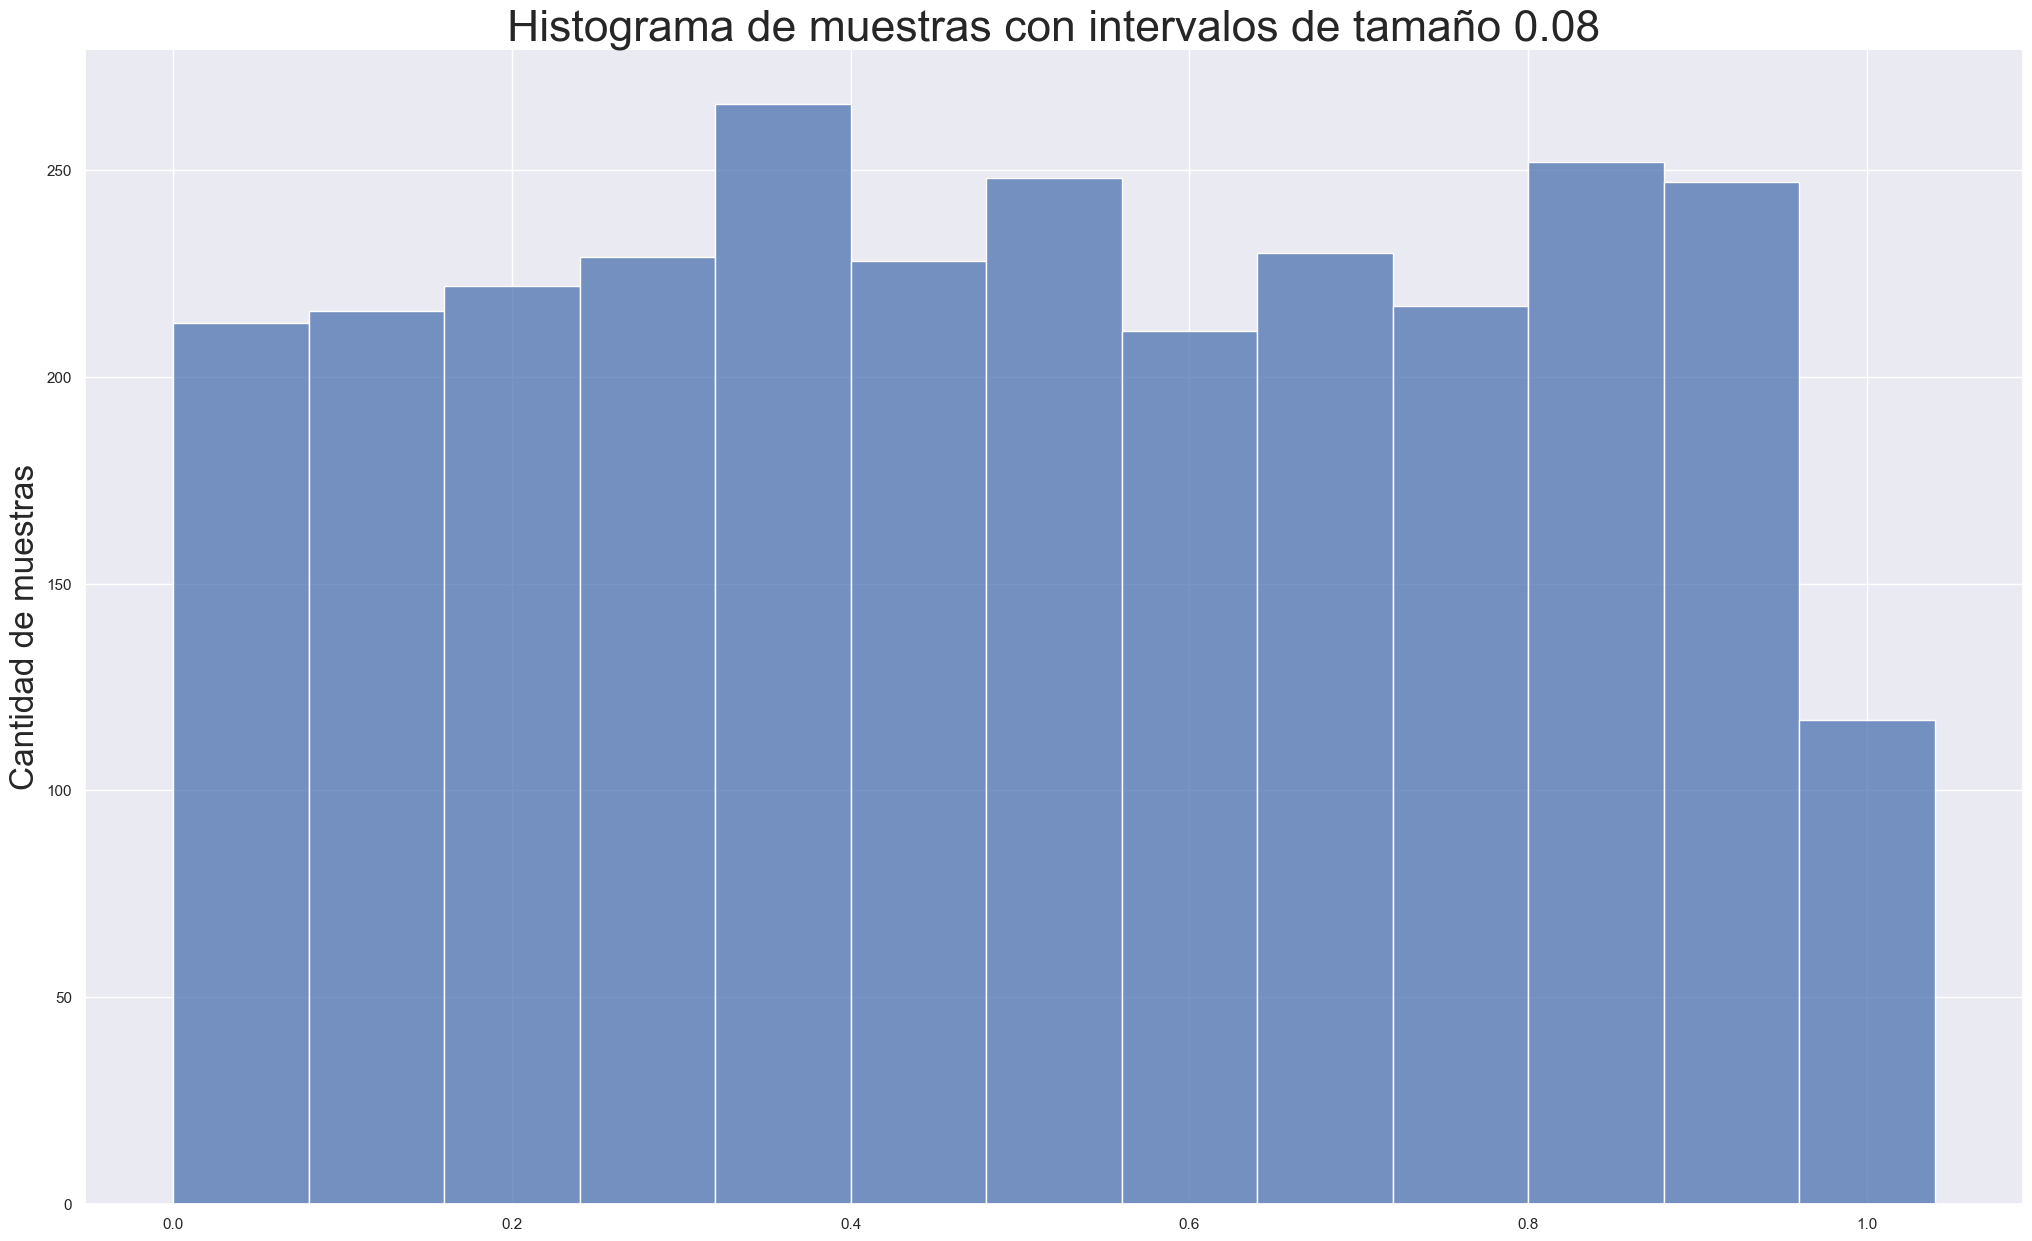

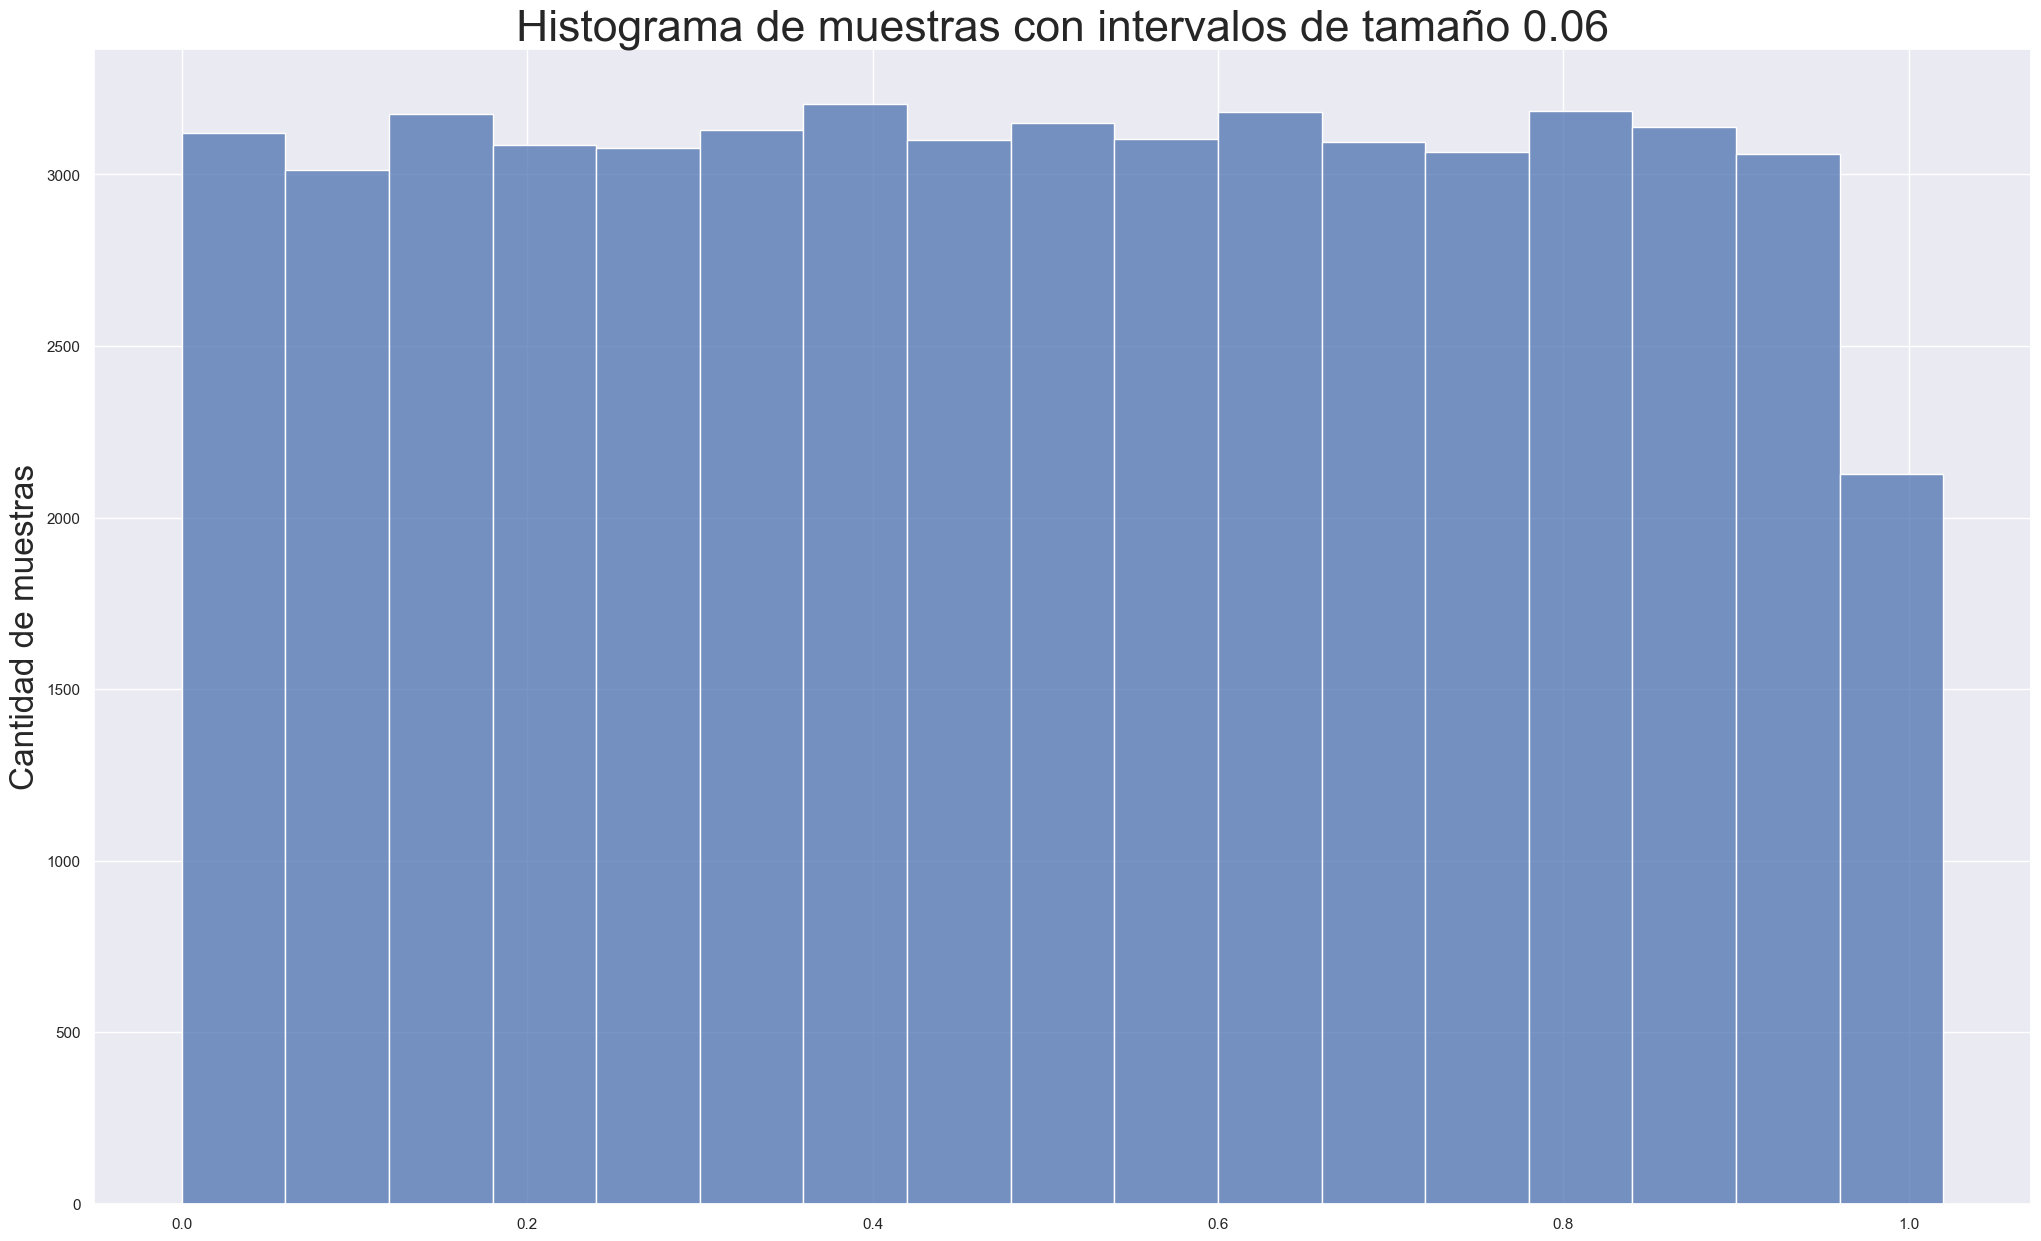

In [ ]:
# Histogramas
g = LXM(42) 

# Regla de Struges
cantidades = [512, 2896, 52016]
intervalos = [0.1, 0.08, 0.06]

for cantidad, intervalo in zip(cantidades, intervalos):
    muestras = []
    for j in range(cantidad):
        muestras.append(next(g))
    
    fig, ax = plt.subplots()
    sns.histplot(data=muestras, binwidth=intervalo, binrange=(0, 1))
    ax.set_title(f"Histograma de muestras con intervalos de tamaño {intervalo}")
    ax.set_ylabel("Cantidad de muestras")
    plt.show()

En un histograma se muestra la cantidad de observaciones de la variable estudiada según el intervalo. Permite observar como se distribuyen los números generados. Por ejemplo, si las barras graficadas tuvieran diferencias significativas en sus alturas esto querría decir que la distribución no es uniforme. En los histogramas hechos, podemos ver que a medida que aumenta la cantidad de muestras usada, y consecuentemente se reduce el tamaño del intervalo, la diferencia que se observa entre las barras disminuye. Esto culmina en el último gráfico, que usa 52016 muestras e intervalos de tamaño 0.06, en el que la longitud de las barras es prácticamente igual. Por esta razón podemos decir que utilizando una cantidad de muestras suficientes (ej: 52016), las muestras tenderán a distribuirse uniformemente en los intervalos.  

Text(0.5, 1.0, 'Boxplot')

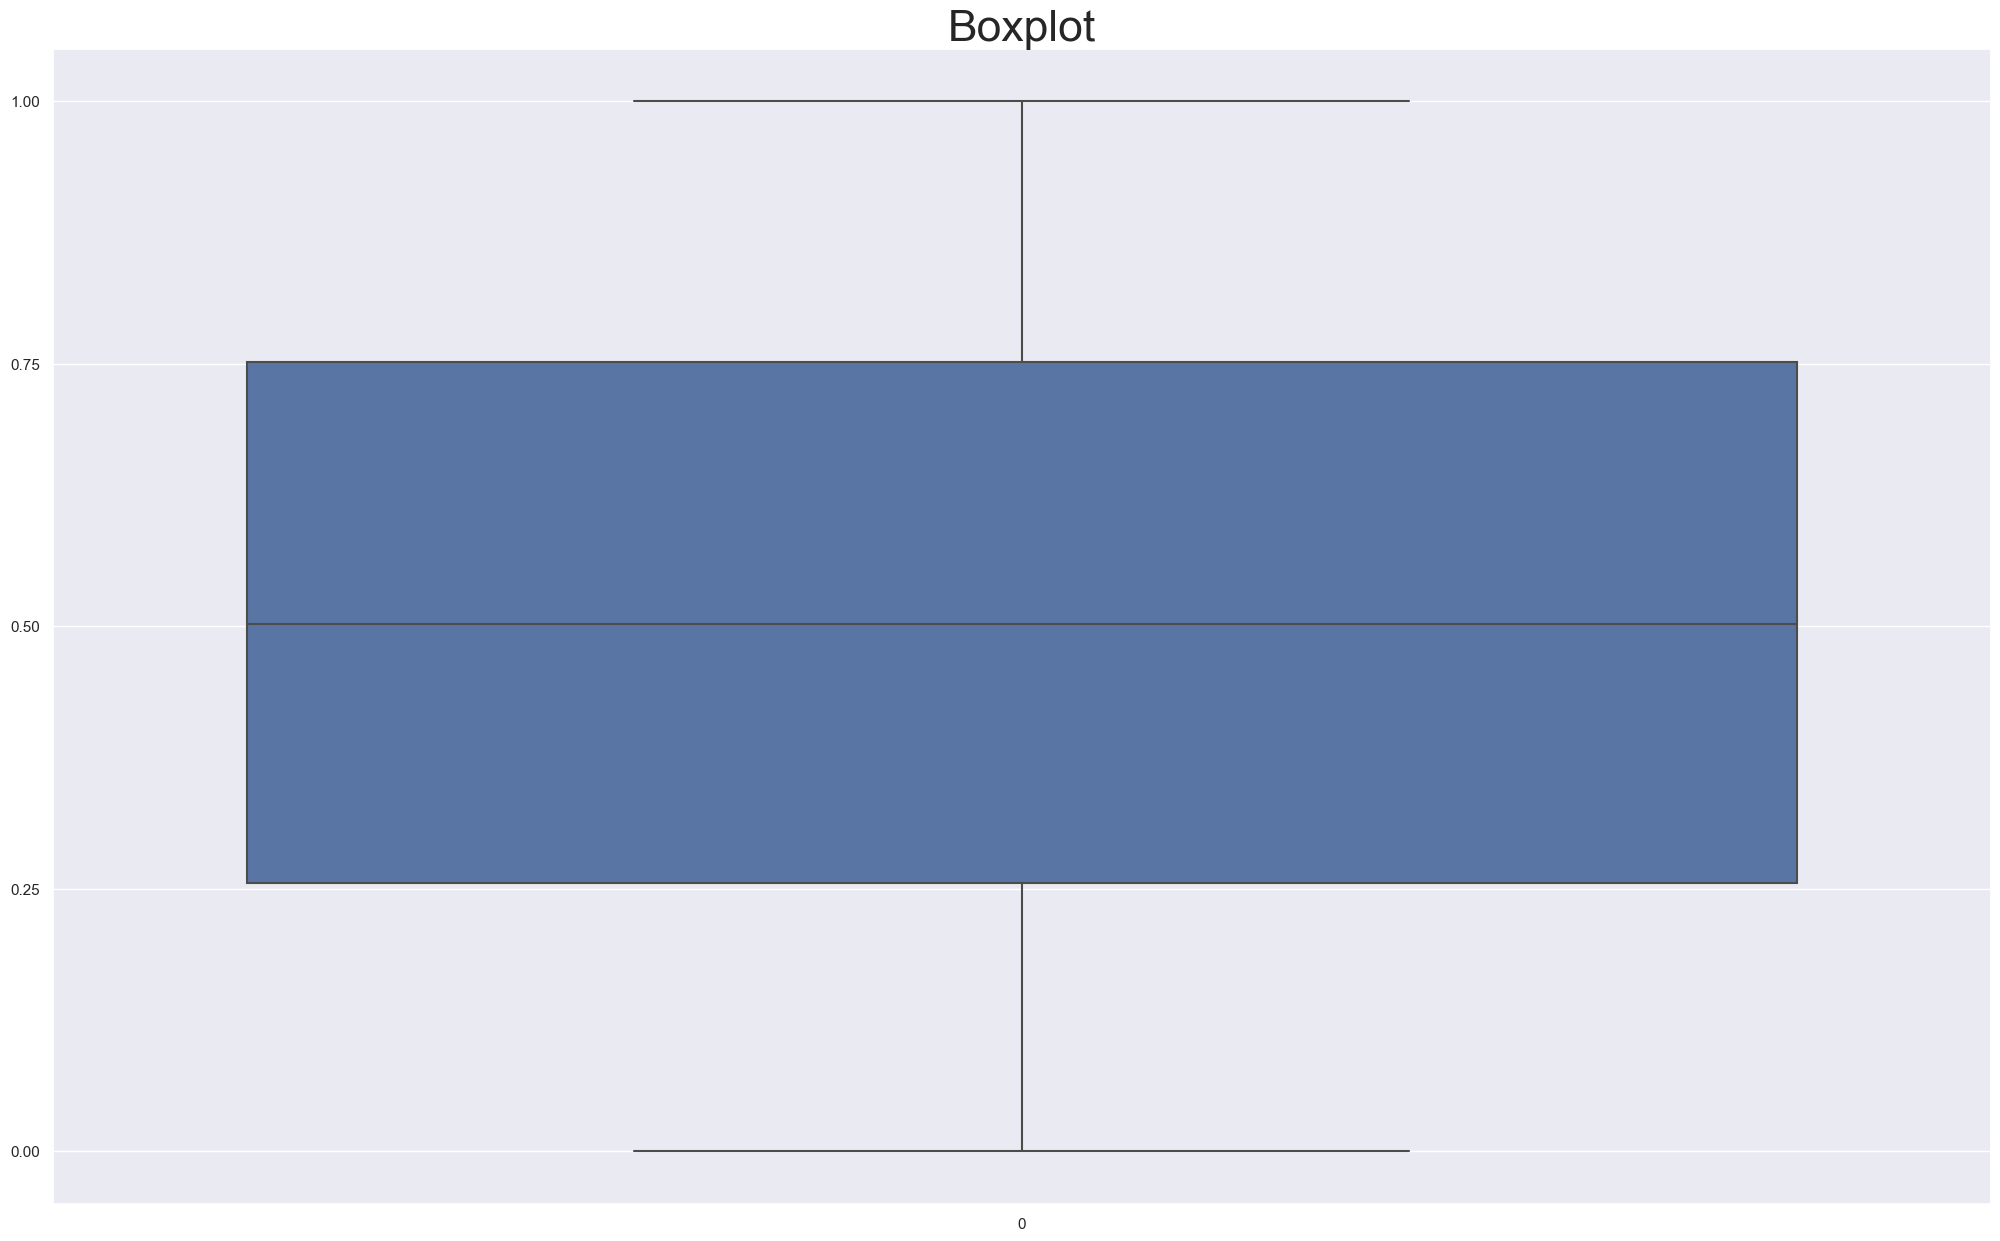

In [ ]:
# Boxplot
g = LXM(42) 
n = 10000

muestras = []
for j in range(n):
    muestras.append(next(g))
    
g = sns.boxplot(muestras)
g.set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.title("Boxplot")

Un boxplot muestra los cuartiles de los números generados, el soporte de la distribución y los outliers. Para el caso actual, se puede utilizar para comparar esos datos con los de una distribución uniforme. Así, se puede ver que:
- Los cuartiles son los esperados. Esto se debe a que el del 25% coincide con 0.25, el de 50% con 0.5 y el de 75% con 0.75
- El soporte es entre 0 y 1
- No se observan outliers 

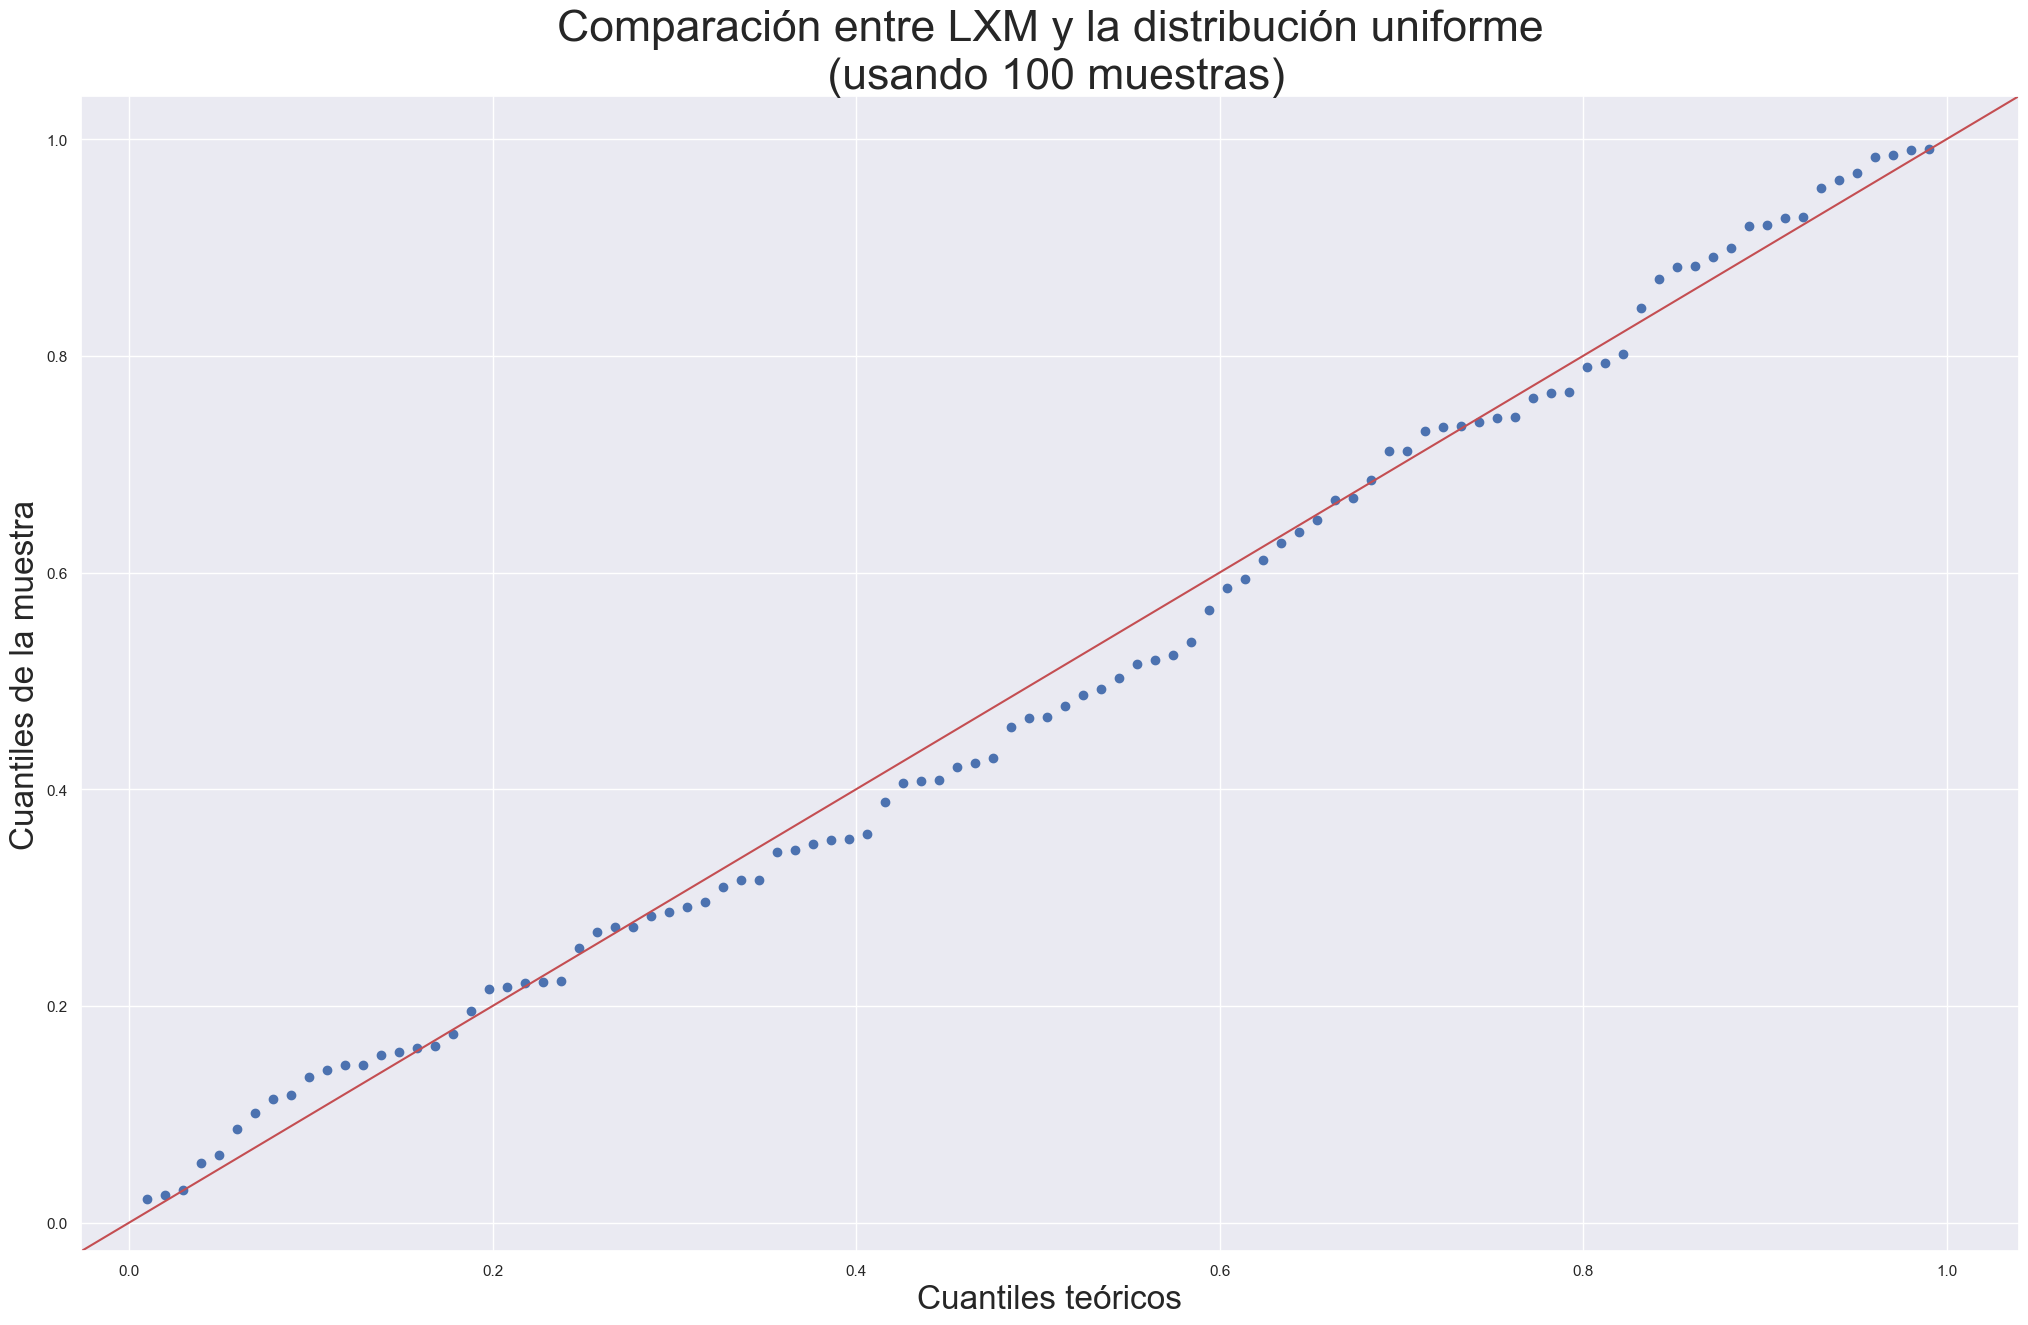

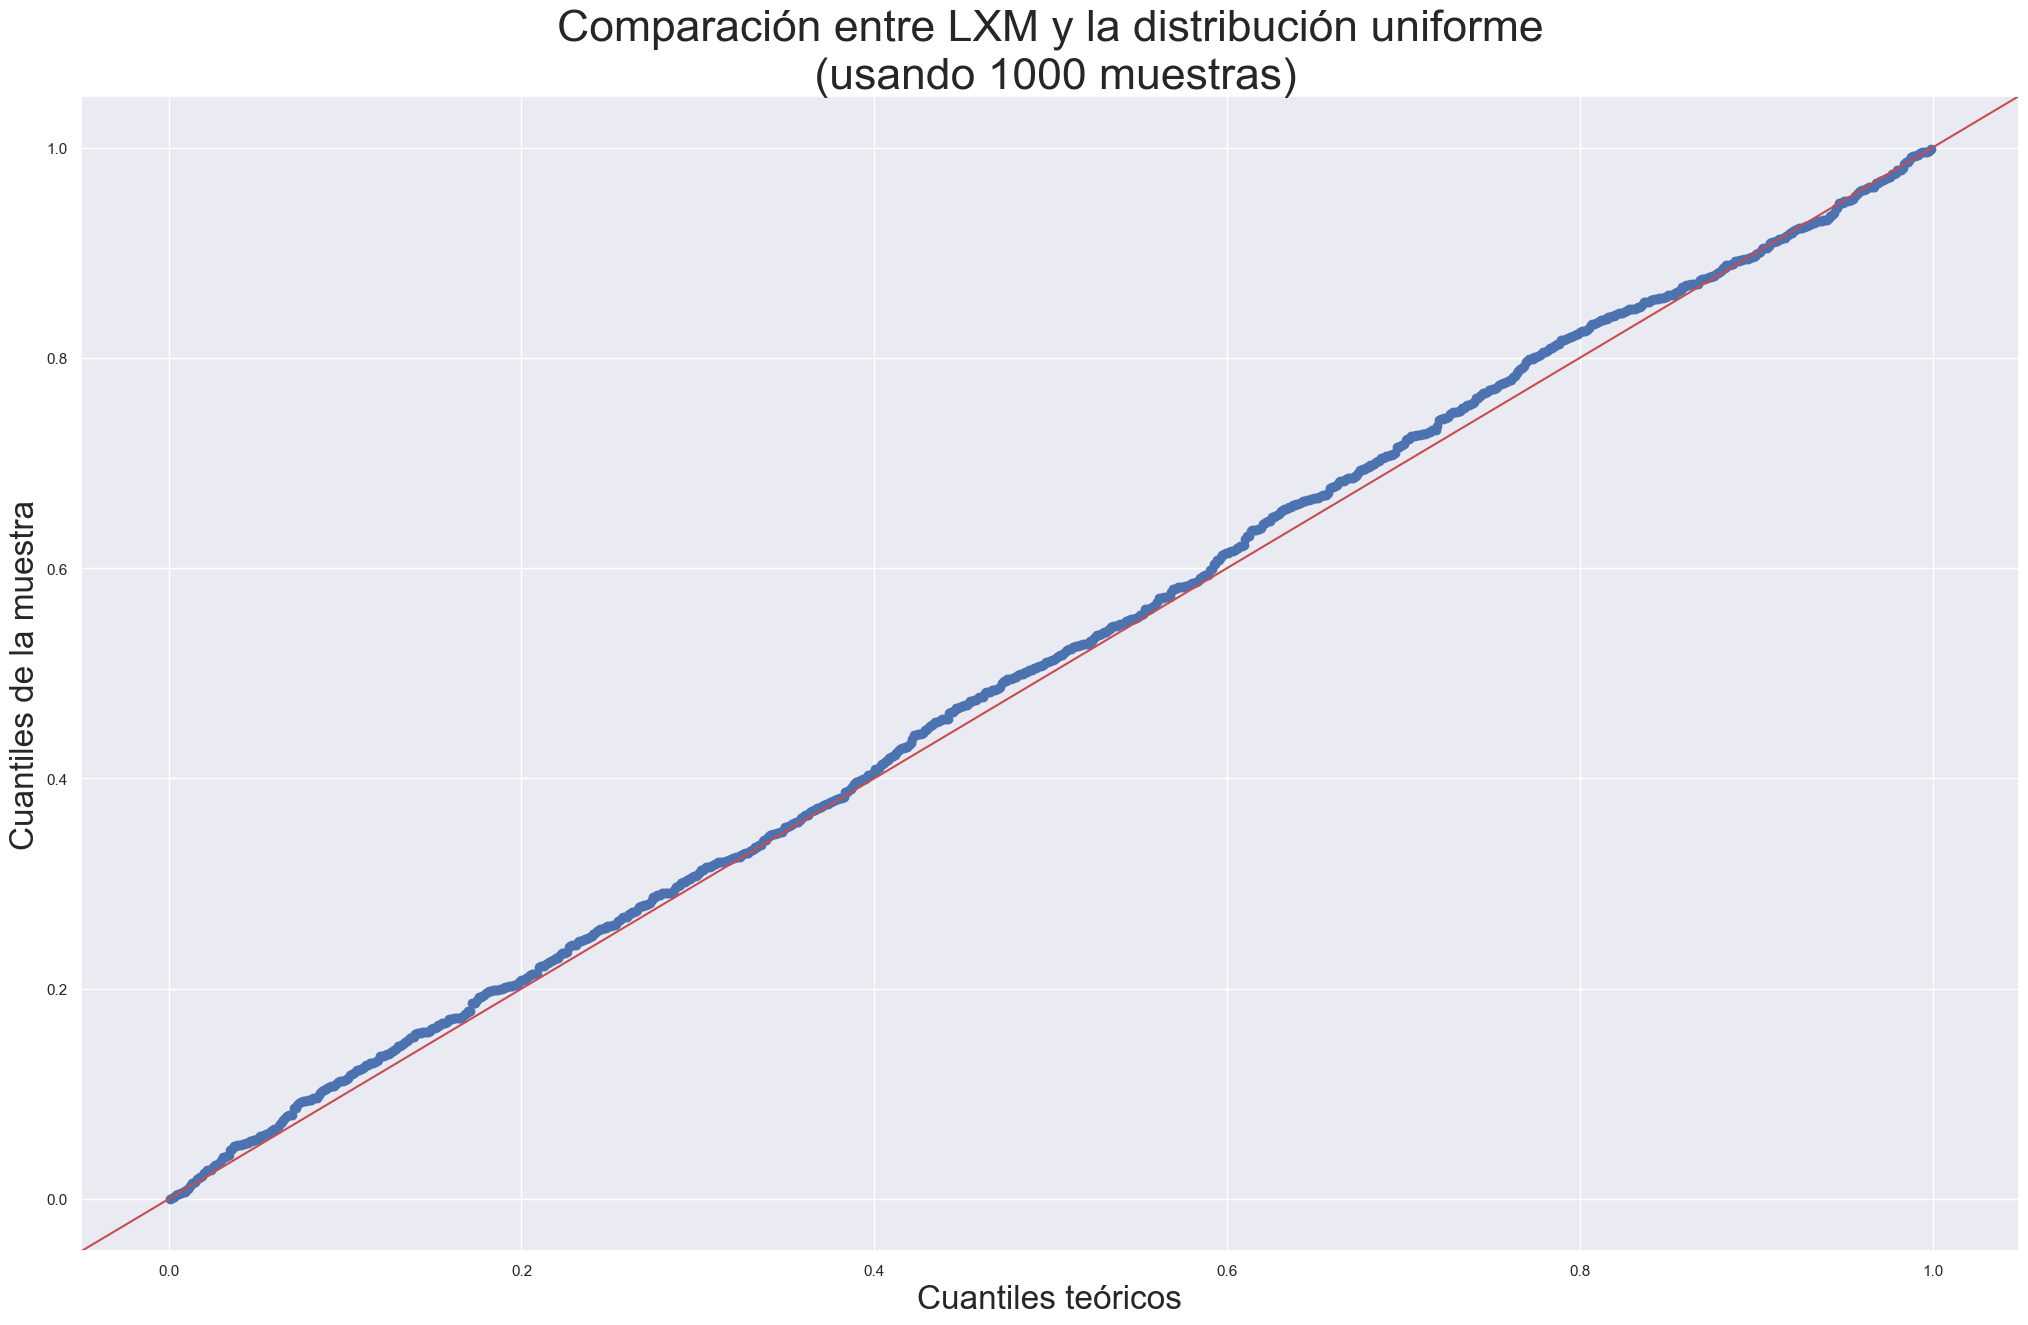

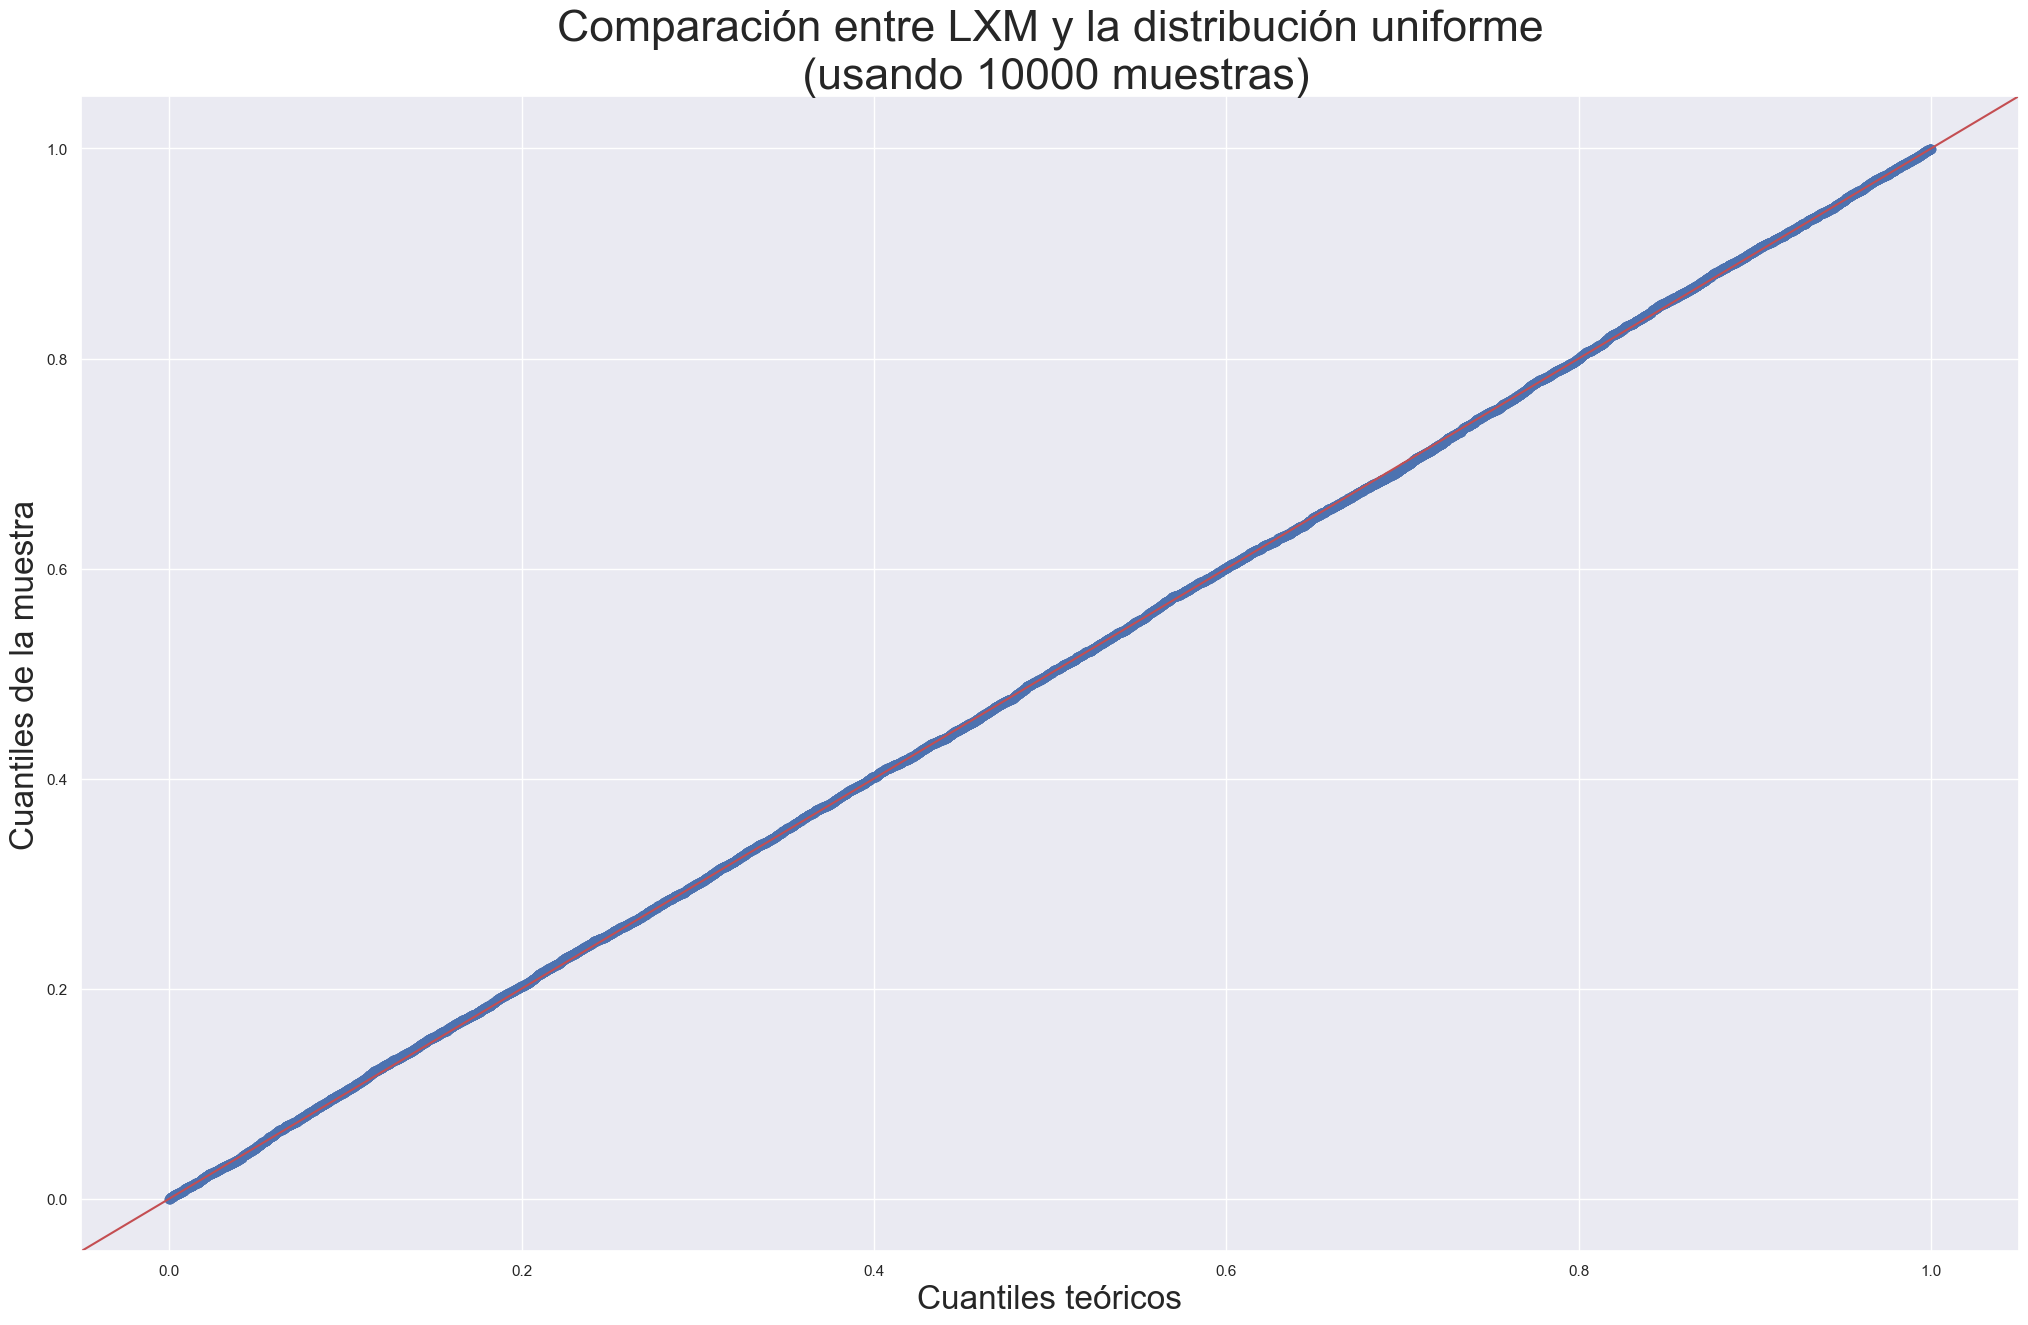

In [ ]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import uniform

g = LXM(42)

# QQPlot
cantidades = [100, 1000, 10000]
for cantidad in cantidades:
    muestras = []
    for j in range(cantidad):
        muestras.append(next(g))
    
    muestras_np = np.array(muestras)
    fig, ax = plt.subplots()
    sm.qqplot(muestras_np, dist=uniform, line='45', ax=ax)
    ax.set_title(f"Comparación entre LXM y la distribución uniforme\n (usando {cantidad} muestras)")
    ax.set_ylabel("Cuantiles de la muestra")
    ax.set_xlabel("Cuantiles teóricos")
    pylab.show()

En el QQplot se comparan los cuantiles de la variable a estudiar, en este caso los de los números generados con LXM, con los de una variable ideal, en este caso una distribución uniforme. Este gráfico permite observar si la probabilidad acumulada a izquierda de cada valor de la variable a estudiar se aleja o no del de la variable ideal.
Se puede ver que si bien en el primer gráfico se observan claras diferencias entre los cuantiles teóricos y los de la muestra, estas pueden ser atribuidas a la baja cantidad de muestras tomadas para dicho gráfico. Lo anterior se debe a que dichas diferencias desaparecen al aumentar la cantidad de muestras en los gráficos siguientes. De hecho, se puede apreciar que en el gráfico hecho utilizando 1000 muestras, aproximadamente entre 0.1 y 0.4 los cuantiles de la muestra se encuentran apenas por debajo de los teóricos, pero esto se corrige en el gráfico hecho 10000 muestras. Por lo tanto, podemos decir que tomando una cantidad de muestras lo suficientemente grande (ej:10000), los cuantiles de los números generados y los de una distribución aleatoria no presentan diferencias.

## Ejercicio 2

Para los generadores implementados en el ejercicio 1:
- Proponer, y realizar, al menos 3 tests para evaluar su comportamiento.
- Evaluar e interpretar los resultados de cada test para distintos tamaños de muestras.

### Chi2

Con este método comparamos dos distribuciones de probabilidad. Por una parte, usaremos el generador que implementamos, y por otra parte, para la distribución esperada.

In [10]:
from scipy.stats import chi2
import numpy as np
import math

class Chi2:
    def __init__(self, numero_de_muestras=1000):
        self._generador = LXM(42)
        self._numero_de_muestras = numero_de_muestras

    def calcular_d2(self):
        numerador = (f_observada - f_esperada) ** 2
        denominador =  f_esperada
        d_al_cuadrado = numerador / denominados # acá es sumatoria
    
    def validar_hipotesis(self, d2, limite_superior):
        if d2 <= limite_superior:
            print("El test acepta la hipotesis nula")
        else:
            print("El test rechaza la hipótesis nula")
        
    def frecuencias_observadas(self):
        # Estas son las que tengo que obtener
        numeros_generados = []
        print(next(self._generador))
        for (_, r), i in zip(self._generador,range(self._numero_de_muestras)):
            numeros_generados.append(r)
        for i in range(self._numero_de_muestras):
            numeros_generados.append(next(self._generador))
        frecuencias = [0] * 10
        for numero in numeros_generados:
            pos = math.floor(numero*10)
            if pos < 10:
                frecuencias[pos] += 1
        return frecuencias

    def realizar_prueba(self):
        frecuencias_observadas = self.frecuencias_observadas()
        print(frecuencias_observadas)
        
        f_esperada = 1/10 * sum(frecuencias_observadas)
        print(f_esperada)
        d2 = sum([(f_observada - f_esperada)**2 for f_observada in frecuencias_observadas]) / f_esperada

        limite_superior = chi2.ppf(0.99, df=4)
        print('Estadístico: {:.2f}'.format(d2))
        print(f'Límite superior: {limite_superior}')
        validar_hipotesis(d2, limite_superior)
        

In [11]:
Chi2(numero_de_muestras=10000).realizar_prueba()

0.793781427453092


TypeError: cannot unpack non-iterable float object

## Ejercicio 3

Utilizando el generador implementado en el ejercicio 1:
- Implementar un método para generar variables aleatorias con distribución normal con media 10 y desvío 2.
- Graficar la distribución que siguen los números pseudoaleatorios generados.
- Realizar, al menos 2 tests, de los explicados en la materia, para verificar si los números generados siguen la distribución pedida (evalué los resultados para distintos tamaños de muestra).

In [ ]:
import random
import scipy as sp

pi = np.pi
e = np.e

In [ ]:
gen = LXM(42)

def generar_exponencial(lambda_):           #OK
    u_1 = next(gen)
    return -np.log(u_1)/lambda_

def cociente(t):                            #OK
    return e**((-(t-1)**2)/2)

def transformar_gaussiana(x, mean, std):    #OK
    return x*std + mean

def generar_normal_0_1():
    no_aceptada = True
    while(no_aceptada):
        exp_1 = generar_exponencial(1)
        prob = cociente(exp_1)                
        if(next(gen) < prob):
            no_aceptada = False
            z = exp_1
            if(next(gen) < 0.5):
                z = -z
    return z

3.b) Graficar la distribución que siguen los números pseudoaleatorios generados.

In [ ]:
m1, m2, m3 = [], [], []     #muestras
for i in range(100):
    z1 = generar_normal_0_1()
    z2 = transformar_gaussiana(z1, 10, 2)
    m1.append(z2)

for i in range(1000):
    z1 = generar_normal_0_1()
    z2 = transformar_gaussiana(z1, 10, 2)
    m2.append(z2)

for i in range(10000):
    z1 = generar_normal_0_1()
    z2 = transformar_gaussiana(z1, 10, 2)
    m3.append(z2)

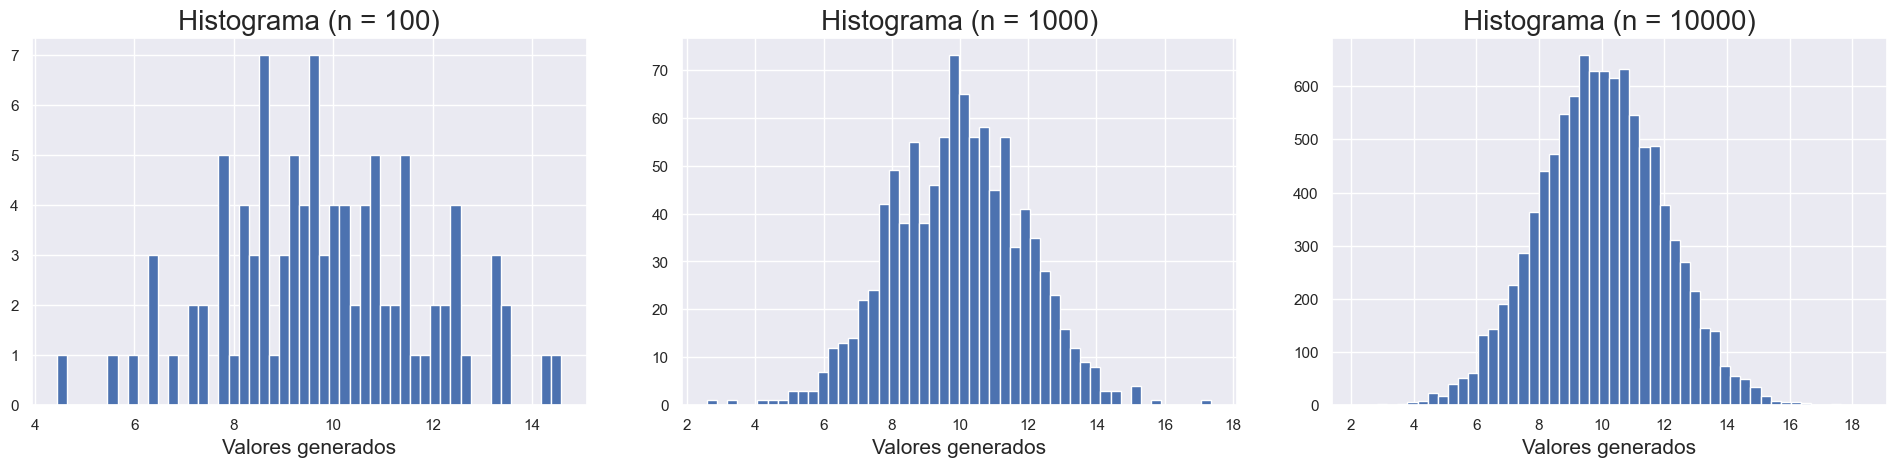

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.tight_layout(pad=3)
ax1.hist(m1, 50)
ax1.set_xlabel('Valores generados', fontsize=15)
ax1.set_title("Histograma (n = 100)", fontsize=20)
ax2.hist(m2, 50)
ax2.set_xlabel('Valores generados', fontsize=15)
ax2.set_title("Histograma (n = 1000)", fontsize=20)
ax3.hist(m3, 50)
ax3.set_xlabel('Valores generados', fontsize=15)
ax3.set_title("Histograma (n = 10000)", fontsize=20)

plt.show();

3.c) Realizar, al menos 2 tests, de los explicados en la materia, para verificar si los números generados siguen la distribución pedida (evalúe los resultados para distintos tamaños de muestra).

3.c.1) Test de Kolmogorov-Smirnov

El test de Kolmogorov-Smirnov se utiliza para decidir si una muestra proviene de una población con una distribución específica. 

Se tiene una distribución de probabilidad acumulada, la cual se propone como distribución teórica de la muestra, y otra distribución de probabilidad empirica, generada a partir de la muestra.

En este caso tenemos las hipótesis:
<br>
<br>
$H_0$: La muestra pertenece a una poblacion con la distribución teórica propuesta
<br>
$H_1$: La muestra no pertenece a una poblacion con la distribución teórica propuesta.
<br>
<br>
El test provee como resultados un estadístico y un p-valor. Cuando el p-valor obtenido es superior a cierto umbral --usualmente 0.05--, decimos que no podemos rechazar la hipótesis de que los datos provienen de una población con la distribución teórica propuesta.

In [ ]:
m1_ks, m2_ks, m3_ks = [], [], []     #muestras
for i in range(100):
    z1 = generar_normal_0_1()
    z2 = transformar_gaussiana(z1, 10, 2)
    m1_ks.append(z2)

for i in range(1000):
    z1 = generar_normal_0_1()
    z2 = transformar_gaussiana(z1, 10, 2)
    m2_ks.append(z2)

for i in range(5000):
    z1 = generar_normal_0_1()
    z2 = transformar_gaussiana(z1, 10, 2)
    m3_ks.append(z2)

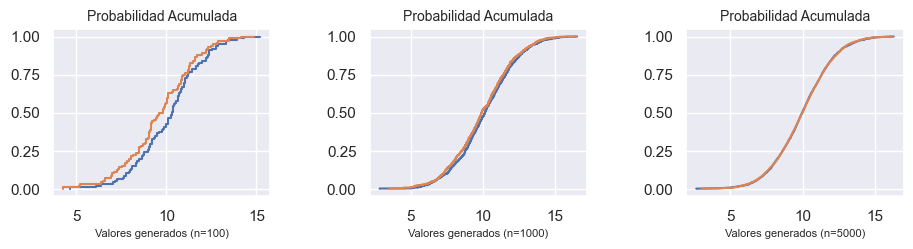

In [ ]:
figsts, (ax1sts, ax2sts, ax3sts) = plt.subplots(1, 3, figsize=(10, 3))
figsts.tight_layout(pad=3)
state = np.random.default_rng()
dist_teorica_1 = sp.stats.norm(loc=10, scale=2).rvs(size=100, random_state=state)
dist_teorica_2 = sp.stats.norm(loc=10, scale=2).rvs(size=1000, random_state=state)
dist_teorica_3 = sp.stats.norm(loc=10, scale=2).rvs(size=5000, random_state=state)

yval1 = np.linspace(0.0, 1.0,num=100)
ax1sts.step(x=np.sort(m1_ks), y=yval1)
ax1sts.step(x=np.sort(dist_teorica_1), y=yval1)
ax1sts.set_xlabel('Valores generados (n=100)', fontsize=8)
ax1sts.set_title("Probabilidad Acumulada", fontsize=10)

yval2 = np.linspace(0.0, 1.0,num=1000)
ax2sts.step(x=np.sort(m2_ks), y=yval2)
ax2sts.step(x=np.sort(dist_teorica_2), y=yval2)
ax2sts.set_xlabel('Valores generados (n=1000)', fontsize=8)
ax2sts.set_title("Probabilidad Acumulada", fontsize=10)

yval3 = np.linspace(0.0, 1.0,num=5000)
ax3sts.step(x=np.sort(m3_ks), y=yval3)
ax3sts.step(x=np.sort(dist_teorica_3), y=yval3)
ax3sts.set_xlabel('Valores generados (n=5000)', fontsize=8)
ax3sts.set_title("Probabilidad Acumulada", fontsize=10)

plt.show();

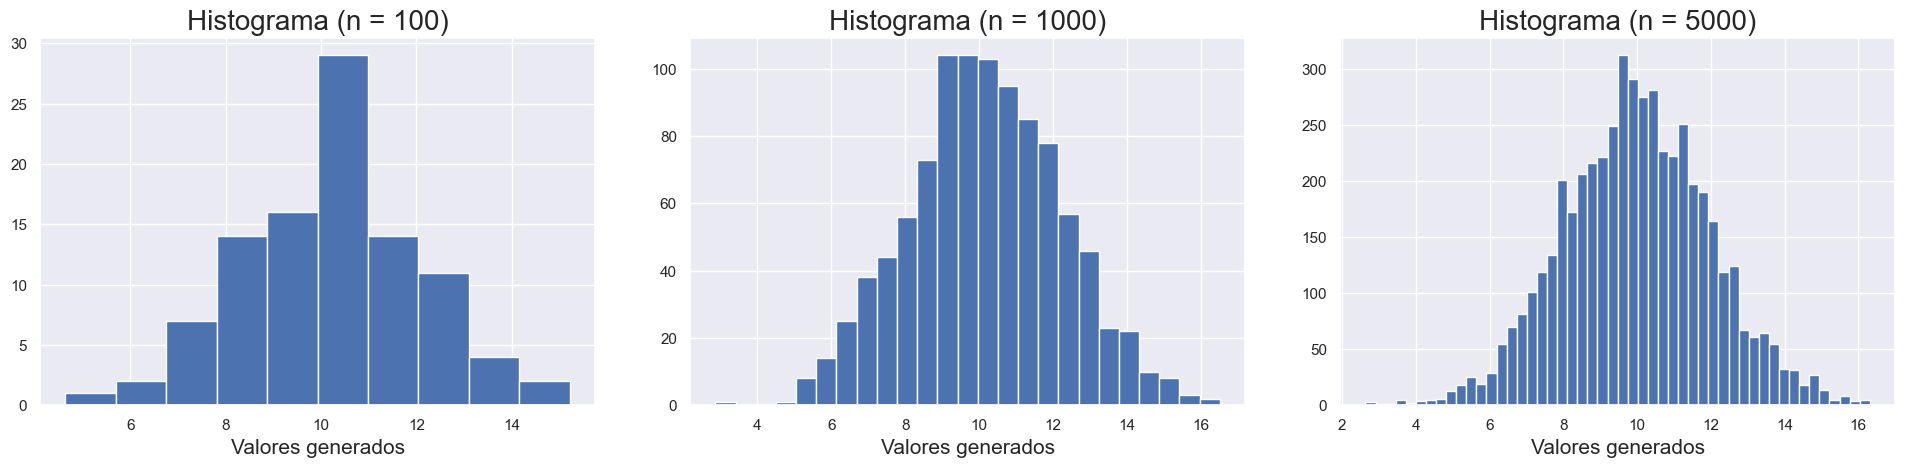

In [ ]:
figks, (ax1ks, ax2ks, ax3ks) = plt.subplots(1, 3, figsize=(20, 5))
figks.tight_layout(pad=3)
ax1ks.hist(m1_ks, 10)
ax1ks.set_xlabel('Valores generados', fontsize=15)
ax1ks.set_title("Histograma (n = 100)", fontsize=20)
ax2ks.hist(m2_ks, 25)
ax2ks.set_xlabel('Valores generados', fontsize=15)
ax2ks.set_title("Histograma (n = 1000)", fontsize=20)
ax3ks.hist(m3_ks, 50)
ax3ks.set_xlabel('Valores generados', fontsize=15)
ax3ks.set_title("Histograma (n = 5000)", fontsize=20)

plt.show();

In [ ]:
from scipy import stats
ks1 = stats.kstest(m1_ks, dist_teorica_1, alternative='two-sided')
ks2 = stats.kstest(m2_ks, dist_teorica_2, alternative='two-sided')
ks3 = stats.kstest(m3_ks, dist_teorica_3, alternative='two-sided')

display ("Valor del estadístico del test Kolmogorov-Smirnov con n = 100: " + str(ks1.statistic))
display ("P-valor del test Kolmogorov-Smirnov con n = 100: " + str(ks1.pvalue))
display ("Valor del estadístico del test Kolmogorov-Smirnov con n = 1000: " + str(ks2.statistic))
display ("P-valor del test Kolmogorov-Smirnov con n = 1000: " + str(ks2.pvalue))
display ("Valor del estadístico del test Kolmogorov-Smirnov con n = 5000: " + str(ks3.statistic))
display ("P-valor del test Kolmogorov-Smirnov con n = 5000: " + str(ks3.pvalue))

'Valor del estadístico del test Kolmogorov-Smirnov con n = 100: 0.18'

'P-valor del test Kolmogorov-Smirnov con n = 100: 0.07822115797841851'

'Valor del estadístico del test Kolmogorov-Smirnov con n = 1000: 0.047'

'P-valor del test Kolmogorov-Smirnov con n = 1000: 0.21939649929677082'

'Valor del estadístico del test Kolmogorov-Smirnov con n = 5000: 0.0094'

'P-valor del test Kolmogorov-Smirnov con n = 5000: 0.9799982681374148'

Dado que en todos los casos el p-valor es superior a 0.05, no rechazamos la hipótesis de que los datos provienen de una distribución normal.

3.c.2) Test de Shapiro-Wilk

El test de Shapiro-Wilk está diseñado para decidir si una muestra aleatoria proviene de una distribución normal. 
En este caso se cuenta con las siguientes hipótesis:

$H_0$: Los datos provienen de una distribución normal

$H_1$: Los datos no provienen de una distribución normal

El test provee como resultados un estadístico y un p-valor. Cuando el p-valor obtenido es superior a cierto umbral --usualmente 0.05--, decimos que no podemos rechazar la hipótesis de que los datos provienen de una distribución normal.

La implementación utilizada (scipy) indica que para muestras de más de 5000 números, se pierde precisión en los valores del test. Por lo que se realizará el test para muestras de tamaños N = 100, 1000 y 5000. (Ver: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html?highlight=shapiro)

In [ ]:
m1_sw, m2_sw, m3_sw = [], [], []     #muestras
for i in range(100):
  z1 = generar_normal_0_1()
  z2 = transformar_gaussiana(z1, 10, 2)
  m1_sw.append(z2)

for i in range(1000):
  z1 = generar_normal_0_1()
  z2 = transformar_gaussiana(z1, 10, 2)
  m2_sw.append(z2)

for i in range(5000):
  z1 = generar_normal_0_1()
  z2 = transformar_gaussiana(z1, 10, 2)
  m3_sw.append(z2)

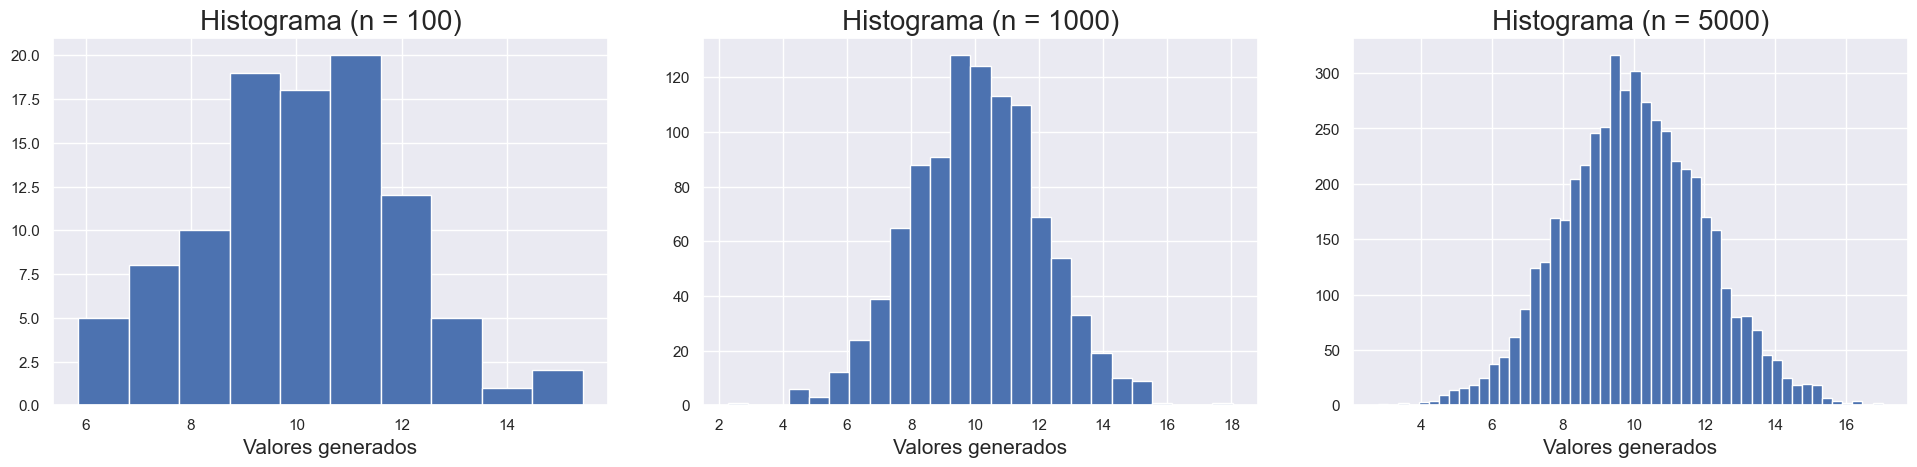

In [ ]:
figsw, (ax1sw, ax2sw, ax3sw) = plt.subplots(1, 3, figsize=(20, 5))
figsw.tight_layout(pad=3)
ax1sw.hist(m1_sw, 10)
ax1sw.set_xlabel('Valores generados', fontsize=15)
ax1sw.set_title("Histograma (n = 100)", fontsize=20)
ax2sw.hist(m2_sw, 25)
ax2sw.set_xlabel('Valores generados', fontsize=15)
ax2sw.set_title("Histograma (n = 1000)", fontsize=20)
ax3sw.hist(m3_sw, 50)
ax3sw.set_xlabel('Valores generados', fontsize=15)
ax3sw.set_title("Histograma (n = 5000)", fontsize=20)

plt.show();


In [ ]:
from scipy import stats
shapiro1 = stats.shapiro(m1_sw)
shapiro2 = stats.shapiro(m2_sw)
shapiro3 = stats.shapiro(m3_sw)

display ("Valor del estadístico del test Shapiro-Wilk con n = 100: " + str(shapiro1.statistic))
display ("P-valor del test Shapiro-Wilk con n = 100: " + str(shapiro1.pvalue))
display ("Valor del estadístico del test Shapiro-Wilk con n = 1000: " + str(shapiro2.statistic))
display ("P-valor del test Shapiro-Wilk con n = 1000: " + str(shapiro2.pvalue))
display ("Valor del estadístico del test Shapiro-Wilk con n = 5000: " + str(shapiro3.statistic))
display ("P-valor del test Shapiro-Wilk con n = 5000: " + str(shapiro3.pvalue))

'Valor del estadístico del test Shapiro-Wilk con n = 100: 0.9904636740684509'

'P-valor del test Shapiro-Wilk con n = 100: 0.7020654678344727'

'Valor del estadístico del test Shapiro-Wilk con n = 1000: 0.9989786744117737'

'P-valor del test Shapiro-Wilk con n = 1000: 0.8619867563247681'

'Valor del estadístico del test Shapiro-Wilk con n = 5000: 0.9995430111885071'

'P-valor del test Shapiro-Wilk con n = 5000: 0.28750666975975037'

Dado que el p-valor es superior a 0.05, no rechazamos la hipótesis de que los datos provienen de una distribución normal.

---

## Ejercicio 4

La llegada de vehículos a un estacionamiento sigue un proceso de Poisson de tasa λ vehículos/hora. En el trabajo práctico se incluye un archivo con números pseudoaleatorios que representan los tiempos entre arribos de dichos vehículos.
- Realice una estimación de la tasa de arribos y proponga un test para evaluar si los números pseudoaleatorios provistos siguen la distribución esperada.
- Utilizando el GCL implementado en el Ejercicio 1 simular la llegada de vehículos durante un mes. Graficar la cantidad de arribos en función del tiempo.
- Generar 1000 realizaciones del proceso de Poisson para estimar las siguientes probabilidades:
  1. Probabilidad que el primer vehículo arribe antes de los 10 minutos.
  2. Probabilidad que el undécimo vehículo arribe después de los 60 minutos.
  3. Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.

Comparar con los valores teóricos.

In [ ]:
arribos_real = []
with open("tiempos_entre_arribos.txt") as f:
    for l in f.readlines(): arribos_real.append(float(l.strip()))

TASA = len(arribos_real)/sum(arribos_real)
print(f"Tengo {len(arribos_real)} arribos en {sum(arribos_real)} horas")
print(f"Mi tasa de arribos empírica es de {TASA} arribos por hora")

Tengo 10000 arribos en 1011.1994386169154 horas
Mi tasa de arribos empírica es de 9.889245996494681 arribos por hora


In [ ]:
# Para generar eventos de Poisson:
#  1. Generar muestras de una distribución exponencial Z, con parametro Lambda: z1, z2, z3...
#  2. Definir tiempos de eventos conteo de Poisson: t0 = 0, t1 = t0 + z1, t2 = t1 + z2....

def iter_exponencial(lmbda, generador, n):
    """Genera una secuencia que siga una distribución exponencial, 
       dado un generador que sigue una distribución uniforme"""
    u = np.array([next(generador) for i in range(int(n))])
    x = -np.log(1-u)/lmbda
    return iter(x)

def generar_poisson(limite, lmbda, generador):
    expo = iter_exponencial(lmbda, generador, lmbda*limite*1.5)
    arribos = []
    t = 0
    while t <= limite:
        arribo = next(expo)
        arribos.append(arribo)
        t += arribo
    return arribos

limite = 24 * 31 # Un mes
arribos = generar_poisson(limite, TASA, LXM(42))

print(f"Simulé {len(arribos)} arribos en {sum(arribos)} horas")
print(f"Mi tasa de arribos simulada es de {len(arribos)/sum(arribos)} arribos por hora")

Simulé 7300 arribos en 744.064522714941 horas
Mi tasa de arribos simulada es de 9.810977109033201 arribos por hora


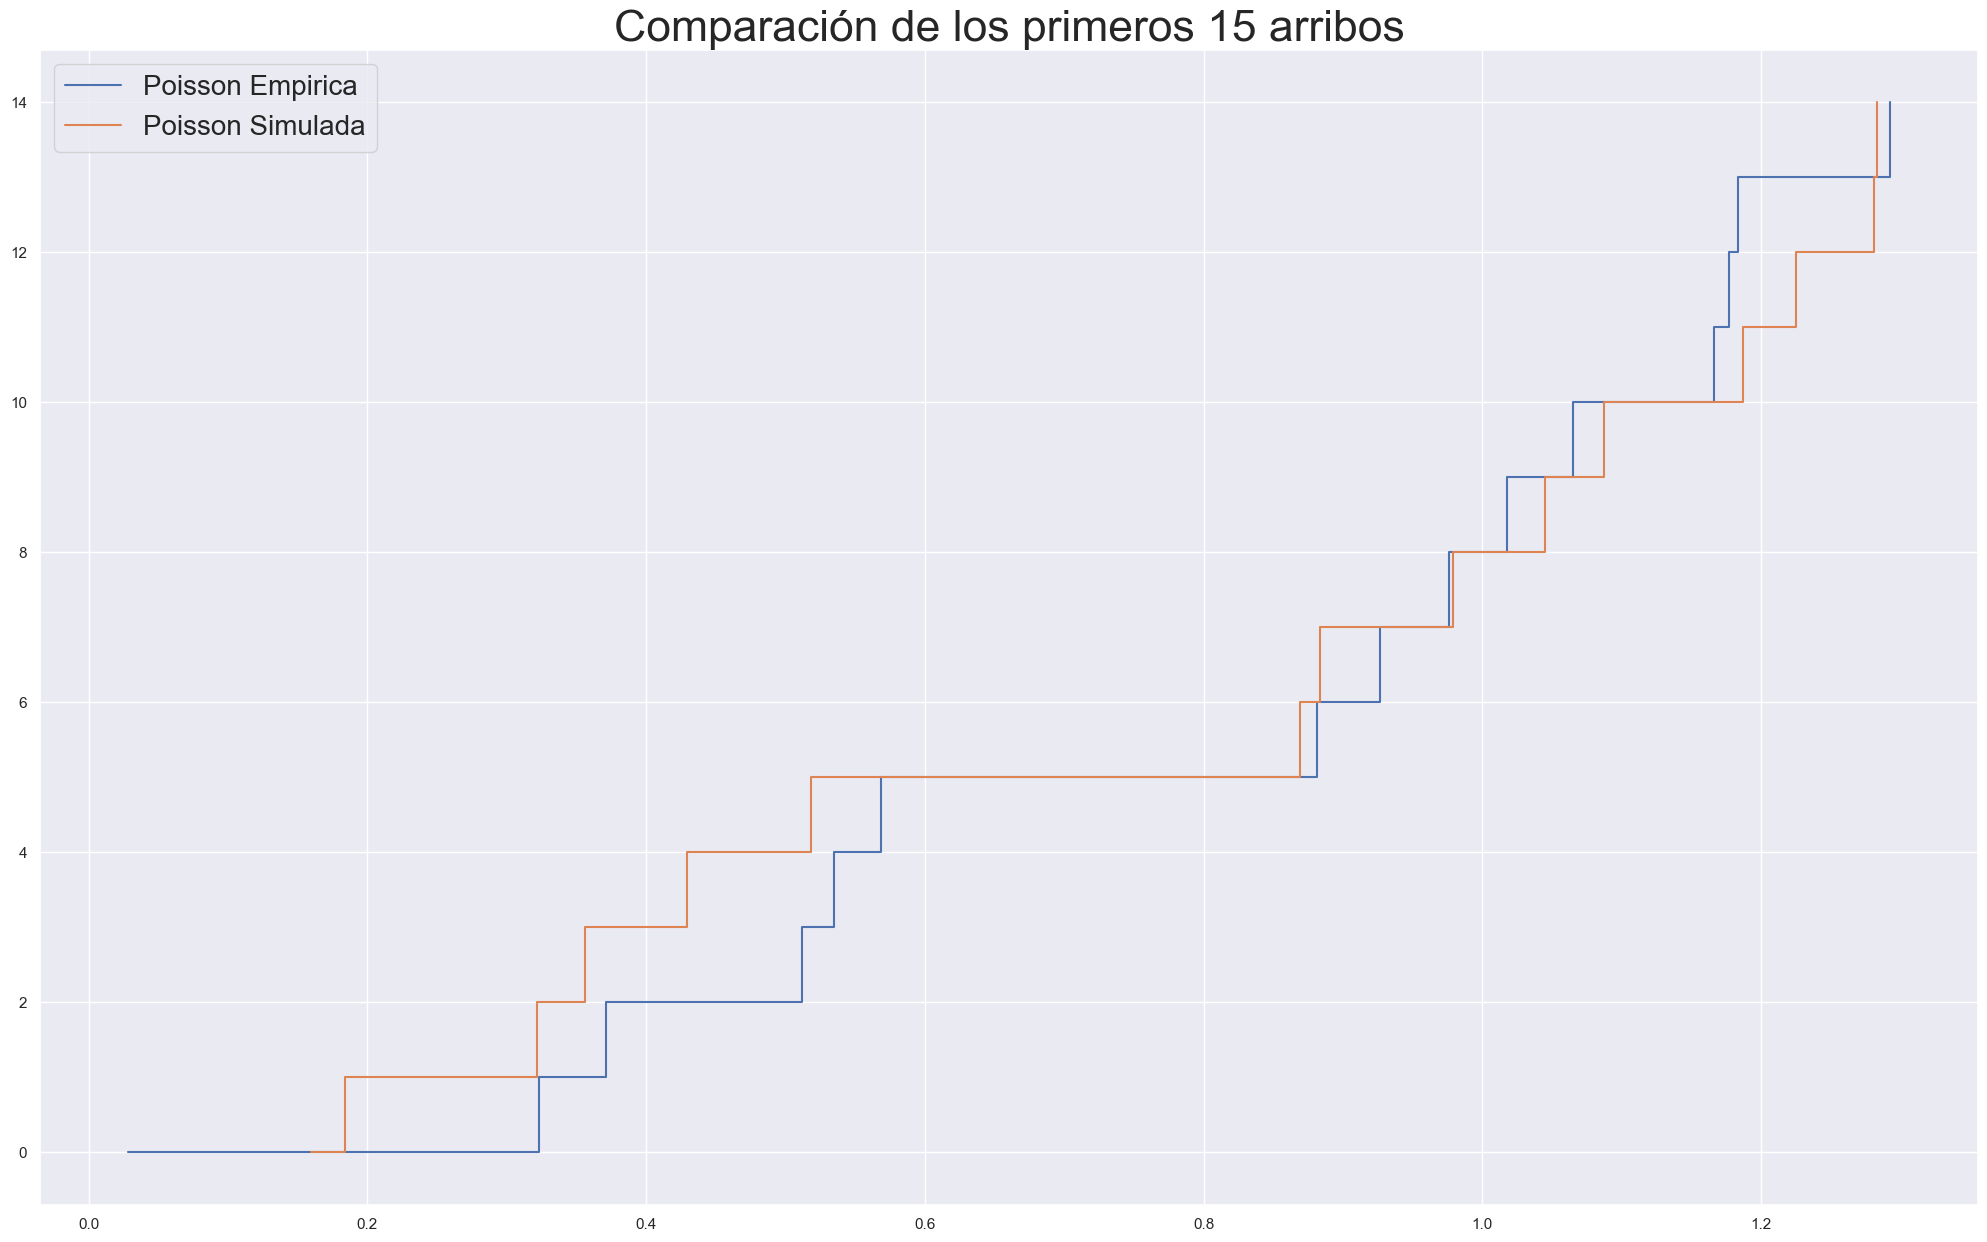

In [ ]:
def comparar_poissones(poissones_con_label, n = 15):
    for arribos, label in poissones_con_label:
        plt.step(np.cumsum(arribos[:n]),range(n),where= 'post',label=label)
    plt.legend()
    plt.title(f"Comparación de los primeros {n} arribos")
    plt.show()

comparar_poissones([(arribos_real, "Poisson Empirica"), (arribos, "Poisson Simulada")])

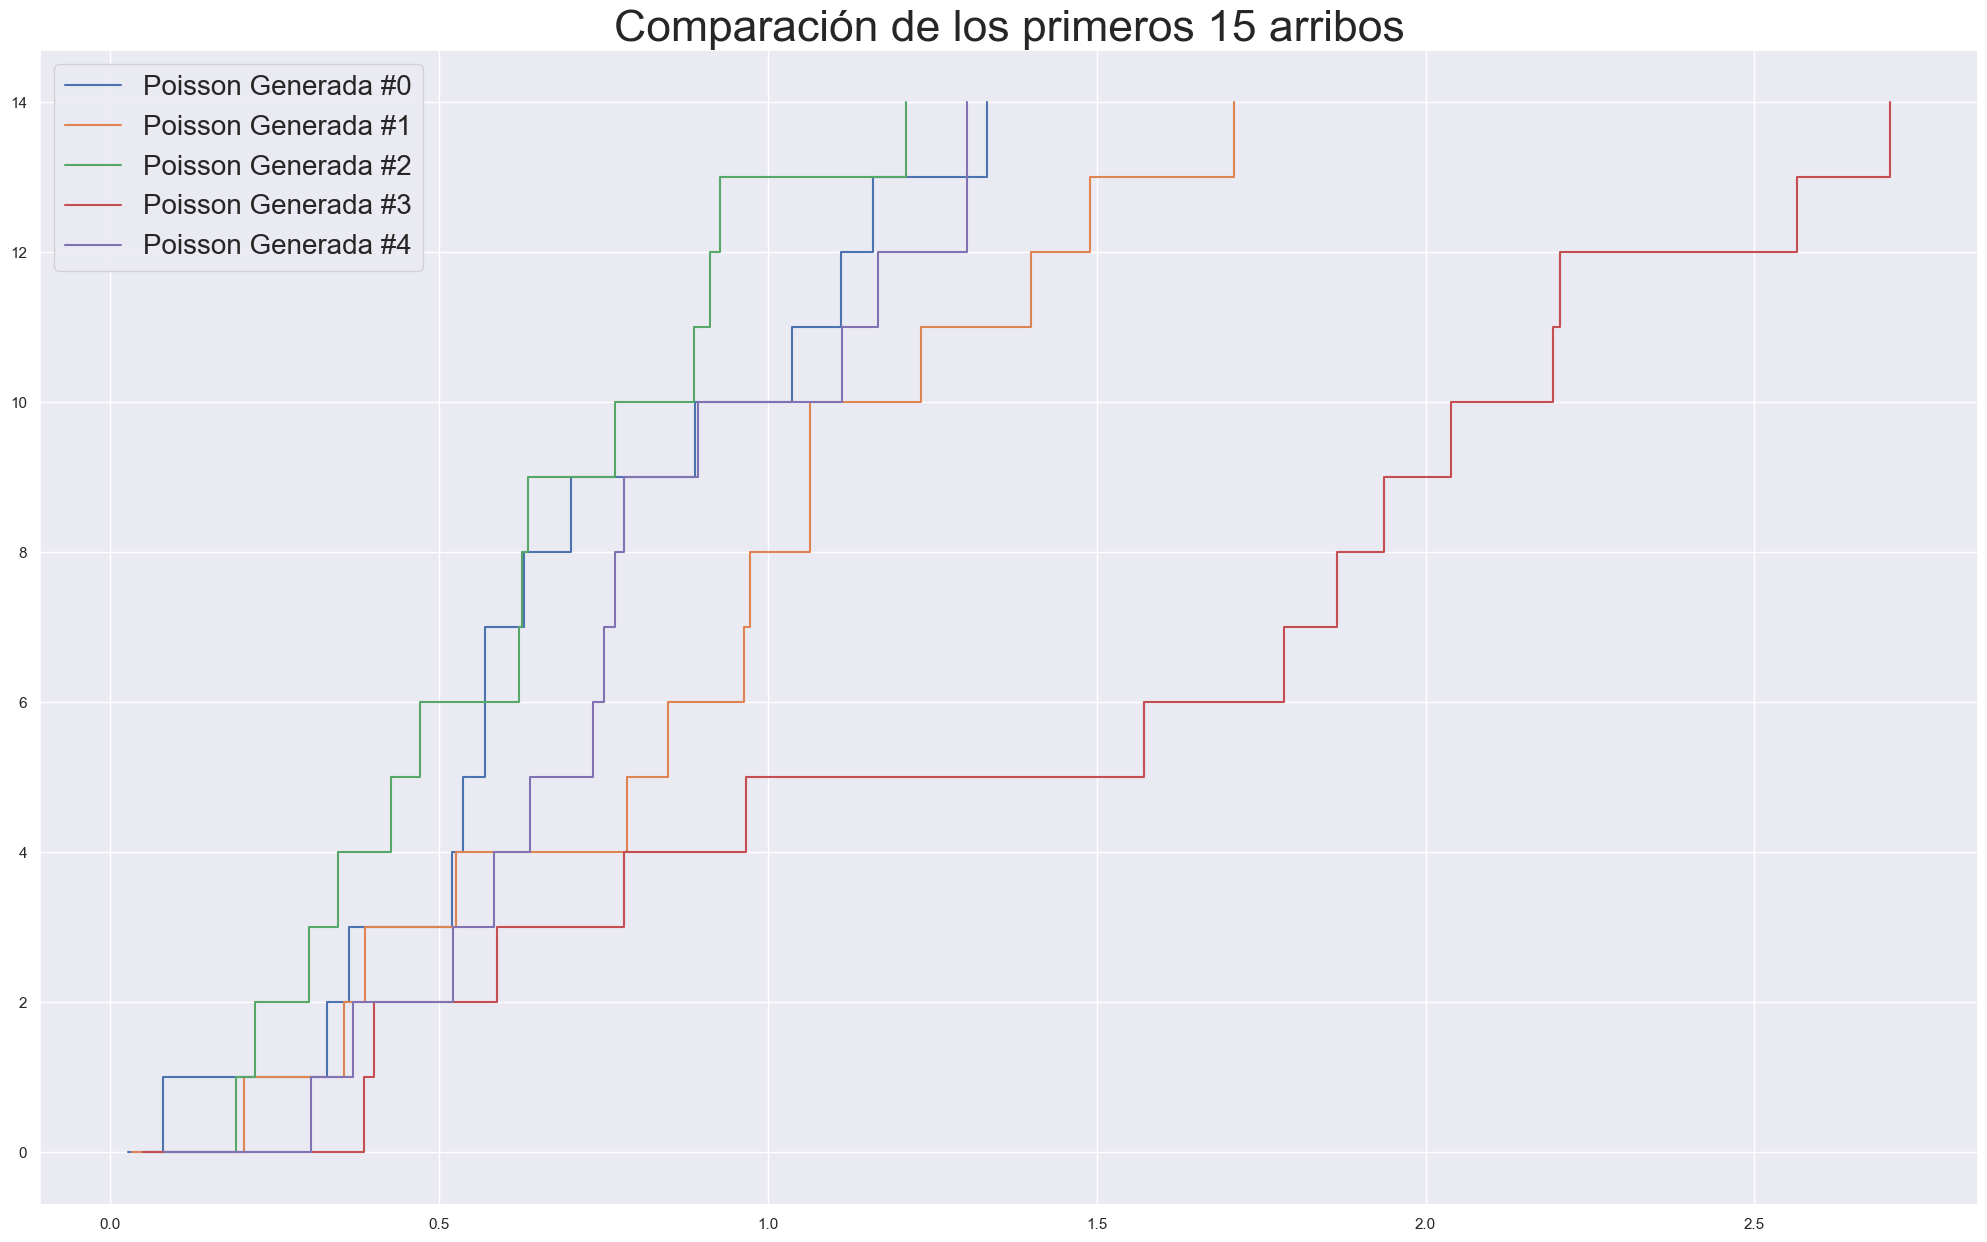

In [ ]:
limite = 96
poissones = []
for i in range(1000):
    poissones.append(generar_poisson(limite, tasa, LXM(i)))
    
comparar_poissones([(p, f"Poisson Generada #{i}") for i, p in enumerate(poissones[:5])])

In [ ]:
import math

# PMF de poisson, a mano, para comparar con los valores teóricos
pmf = lambda x, lmbda: ((lmbda ** x) * (math.e ** -lmbda)) / (math.factorial(x))

print("Probabilidad que el primer vehículo arribe antes de los 10 minutos.")
diez_min = 1/6


# La probabilidad de que haya al menos un arribo en 10 minutos equivale a
#   1 - la probabilidad de que no haya ningun arribo en 10 minutos
print(f"* Probabilidad Teórica => {1 - pmf(0, tasa*diez_min)}")

favorable = []
for p in poissones:
    favorable.append(p[0] <= diez_min)

print(f"* Probabilidad Simulada => {sum(favorable)/len(favorable)}")

Probabilidad que el primer vehículo arribe antes de los 10 minutos.
* Probabilidad Teórica => 0.8076055651533732
* Probabilidad Simulada => 0.818


In [ ]:
print("Probabilidad que el undécimo vehículo arribe después de los 60 minutos.")
sesenta_min = 1

# La probabilidad de que el vehiculo 11 llegué despues de 60 minutos equivale a
#   la sumatoria de que hayan llegado 0,1,2,...,10 vehiculos en 60 minutos
# Ojo con los off-by-one! `for i in range(11)` === de 0 a 10
print(f"* Probabilidad Teórica => {sum([pmf(i, tasa*sesenta_min) for i in range(11)])}")

favorable = []
for p in poissones:
    arribos_acumulados = np.cumsum(p)
    # El arribo en el indice [10] === El undecimo arribo
    favorable.append(arribos_acumulados[10] >= 1)

print(f"* Probabilidad Simulada => {sum(favorable)/len(favorable)}")

Probabilidad que el undécimo vehículo arribe después de los 60 minutos.
* Probabilidad Teórica => 0.596893339441658
* Probabilidad Simulada => 0.579


In [ ]:
# Como nuestra pmf a mano da overflow al calcular un número grande como lambda a la 750,
#   importamos directamente el modulo de scipy
from scipy.stats import poisson

print("Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.")
setentidos_horas = 72

# La probabilidad de que arriben al menos 750 vehiculos en 72 horas equivale a
#   1 - la sumatoria de que lleguen 0,1,...,749 en 72 horas
print(f"* Probabilidad Teórica => {1 - sum([poisson.pmf(i, tasa*setentidos_horas) for i in range(750)])}")

favorable = []
for p in poissones:
    arribos_acumulados = np.cumsum(p)
    favorable.append(arribos_acumulados[749] <= 72)

print(f"* Probabilidad Simulada => {sum(favorable)/len(favorable)}")

Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.
* Probabilidad Teórica => 0.0809784853589276
* Probabilidad Simulada => 0.084


## Ejercicio 5

A partir del generador de número al azar implementado en el ejercicio 1, y del dataset provisto, obtenido del sitio de datos abiertos del Gobierno de la Ciudad de Buenos Aires (data.buenosaires.gob.ar), el cual contiene información geográfica de barrios de la Ciudad de Buenos Aires, se pide:
- Proponer e implementar un método que permita generar coordenadas (latitud y longitud) distribuidas de forma uniforme en cada uno de los barrios.
- Graficar los puntos generados en el mapa

## Ejercicio 6
Comparar los resultados obtenidos en los ejercicios 1 a 5 utilizando el generador de números al azar propuesto en el paper asignado, con los resultados que se obtendrían con un Generador Congruencial Lineal de módulo 232, multiplicador 1013904223, incremento de 1664525 y semilla igual a la parte entera del promedio de los números de padrón de los integrantes del grupo.